In [1]:
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar,minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from scipy import stats
from multiprocessing import Process,Queue,Pool
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import pickle as pkl
import importlib
from matplotlib.backends.backend_pdf import PdfPages
import sys
sys.path.append("../src/")
from flux_finding_mp import *
rd.seed(1000)
np.random.seed(1000)
from functools import partial
import seaborn as sb
from sklearn.metrics import r2_score

In [2]:
numCores = 20
numBestFitIters = 10
numSims = 100
ts = np.linspace(0,50,100)

In [3]:
data,lacE,glycolysis,fluxes,conc,c0s,vhvds = generateSyntheticData(ts,0.00)
print(conc)
print(vhvds)
conc["NADH"] = 1.0
data

{'Lactate': 0.41543095304490785, 'G3P': 0.02898165938687125, 'Malate': 0.9820274845981977, 'NADH': 0.33963768363528857}
{'vhvd_nadh_ldh': 1.1461652571800935, 'vhvd_nadh_mas': 4.709590608729503, 'vhvd_gap_gapdh': 24.56421560434773, 'vhvd_nadh_g3ps': 2.5176584703924934, 'vhvd_dhap_g3ps': 4.289411807437541, 'vhvd_nadh_dhap_g3ps': 1.1880142794414201}


,UL_lac,UL_g3p,UL_malate,UL_nadh,UL_gap,L_lac,L_malate,L_nadh,L_gap,L_g3p_M+1,L_g3p_M+2
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.999321,0.969857,0.999893,0.994663,0.627693,0.000679,0.000107,0.005337,0.372307,0.029742,0.000401
2,0.997500,0.940057,0.999589,0.988137,0.539783,0.002500,0.000411,0.011863,0.460217,0.058162,0.001782
3,0.995147,0.924987,0.999169,0.983926,0.519025,0.004853,0.000831,0.016074,0.480975,0.071675,0.003338
4,0.992961,0.918563,0.998744,0.981624,0.514124,0.007039,0.001256,0.018376,0.485876,0.076974,0.004463
...,...,...,...,...,...,...,...,...,...,...,...
95,0.987498,0.914253,0.997184,0.979332,0.512609,0.012502,0.002816,0.020668,0.487391,0.079882,0.005865
96,0.987498,0.914253,0.997184,0.979332,0.512609,0.012502,0.002816,0.020668,0.487391,0.079882,0.005865
97,0.987498,0.914253,0.997184,0.979332,0.512609,0.012502,0.002816,0.020668,0.487391,0.079882,0.005865
98,0.987498,0.914253,0.997184,0.979332,0.512609,0.012502,0.002816,0.020668,0.487391,0.079882,0.005865


In [4]:
vhvds = {key:val for key,val in vhvds.items() if key != "vhvd_gap_gapdh"}
vhvds

{'vhvd_nadh_ldh': 1.1461652571800935,
 'vhvd_nadh_mas': 4.709590608729503,
 'vhvd_nadh_g3ps': 2.5176584703924934,
 'vhvd_dhap_g3ps': 4.289411807437541,
 'vhvd_nadh_dhap_g3ps': 1.1880142794414201}

[0.44495764 0.81972867 0.57450789 0.42757956]
-1 0.6958208096995455
[0.28084161 0.04941746 0.40832806 0.5173702 ]
{'Lactate': 0.41543095304490785, 'G3P': 0.02898165938687125, 'Malate': 0.9820274845981977, 'NADH': 1.0}


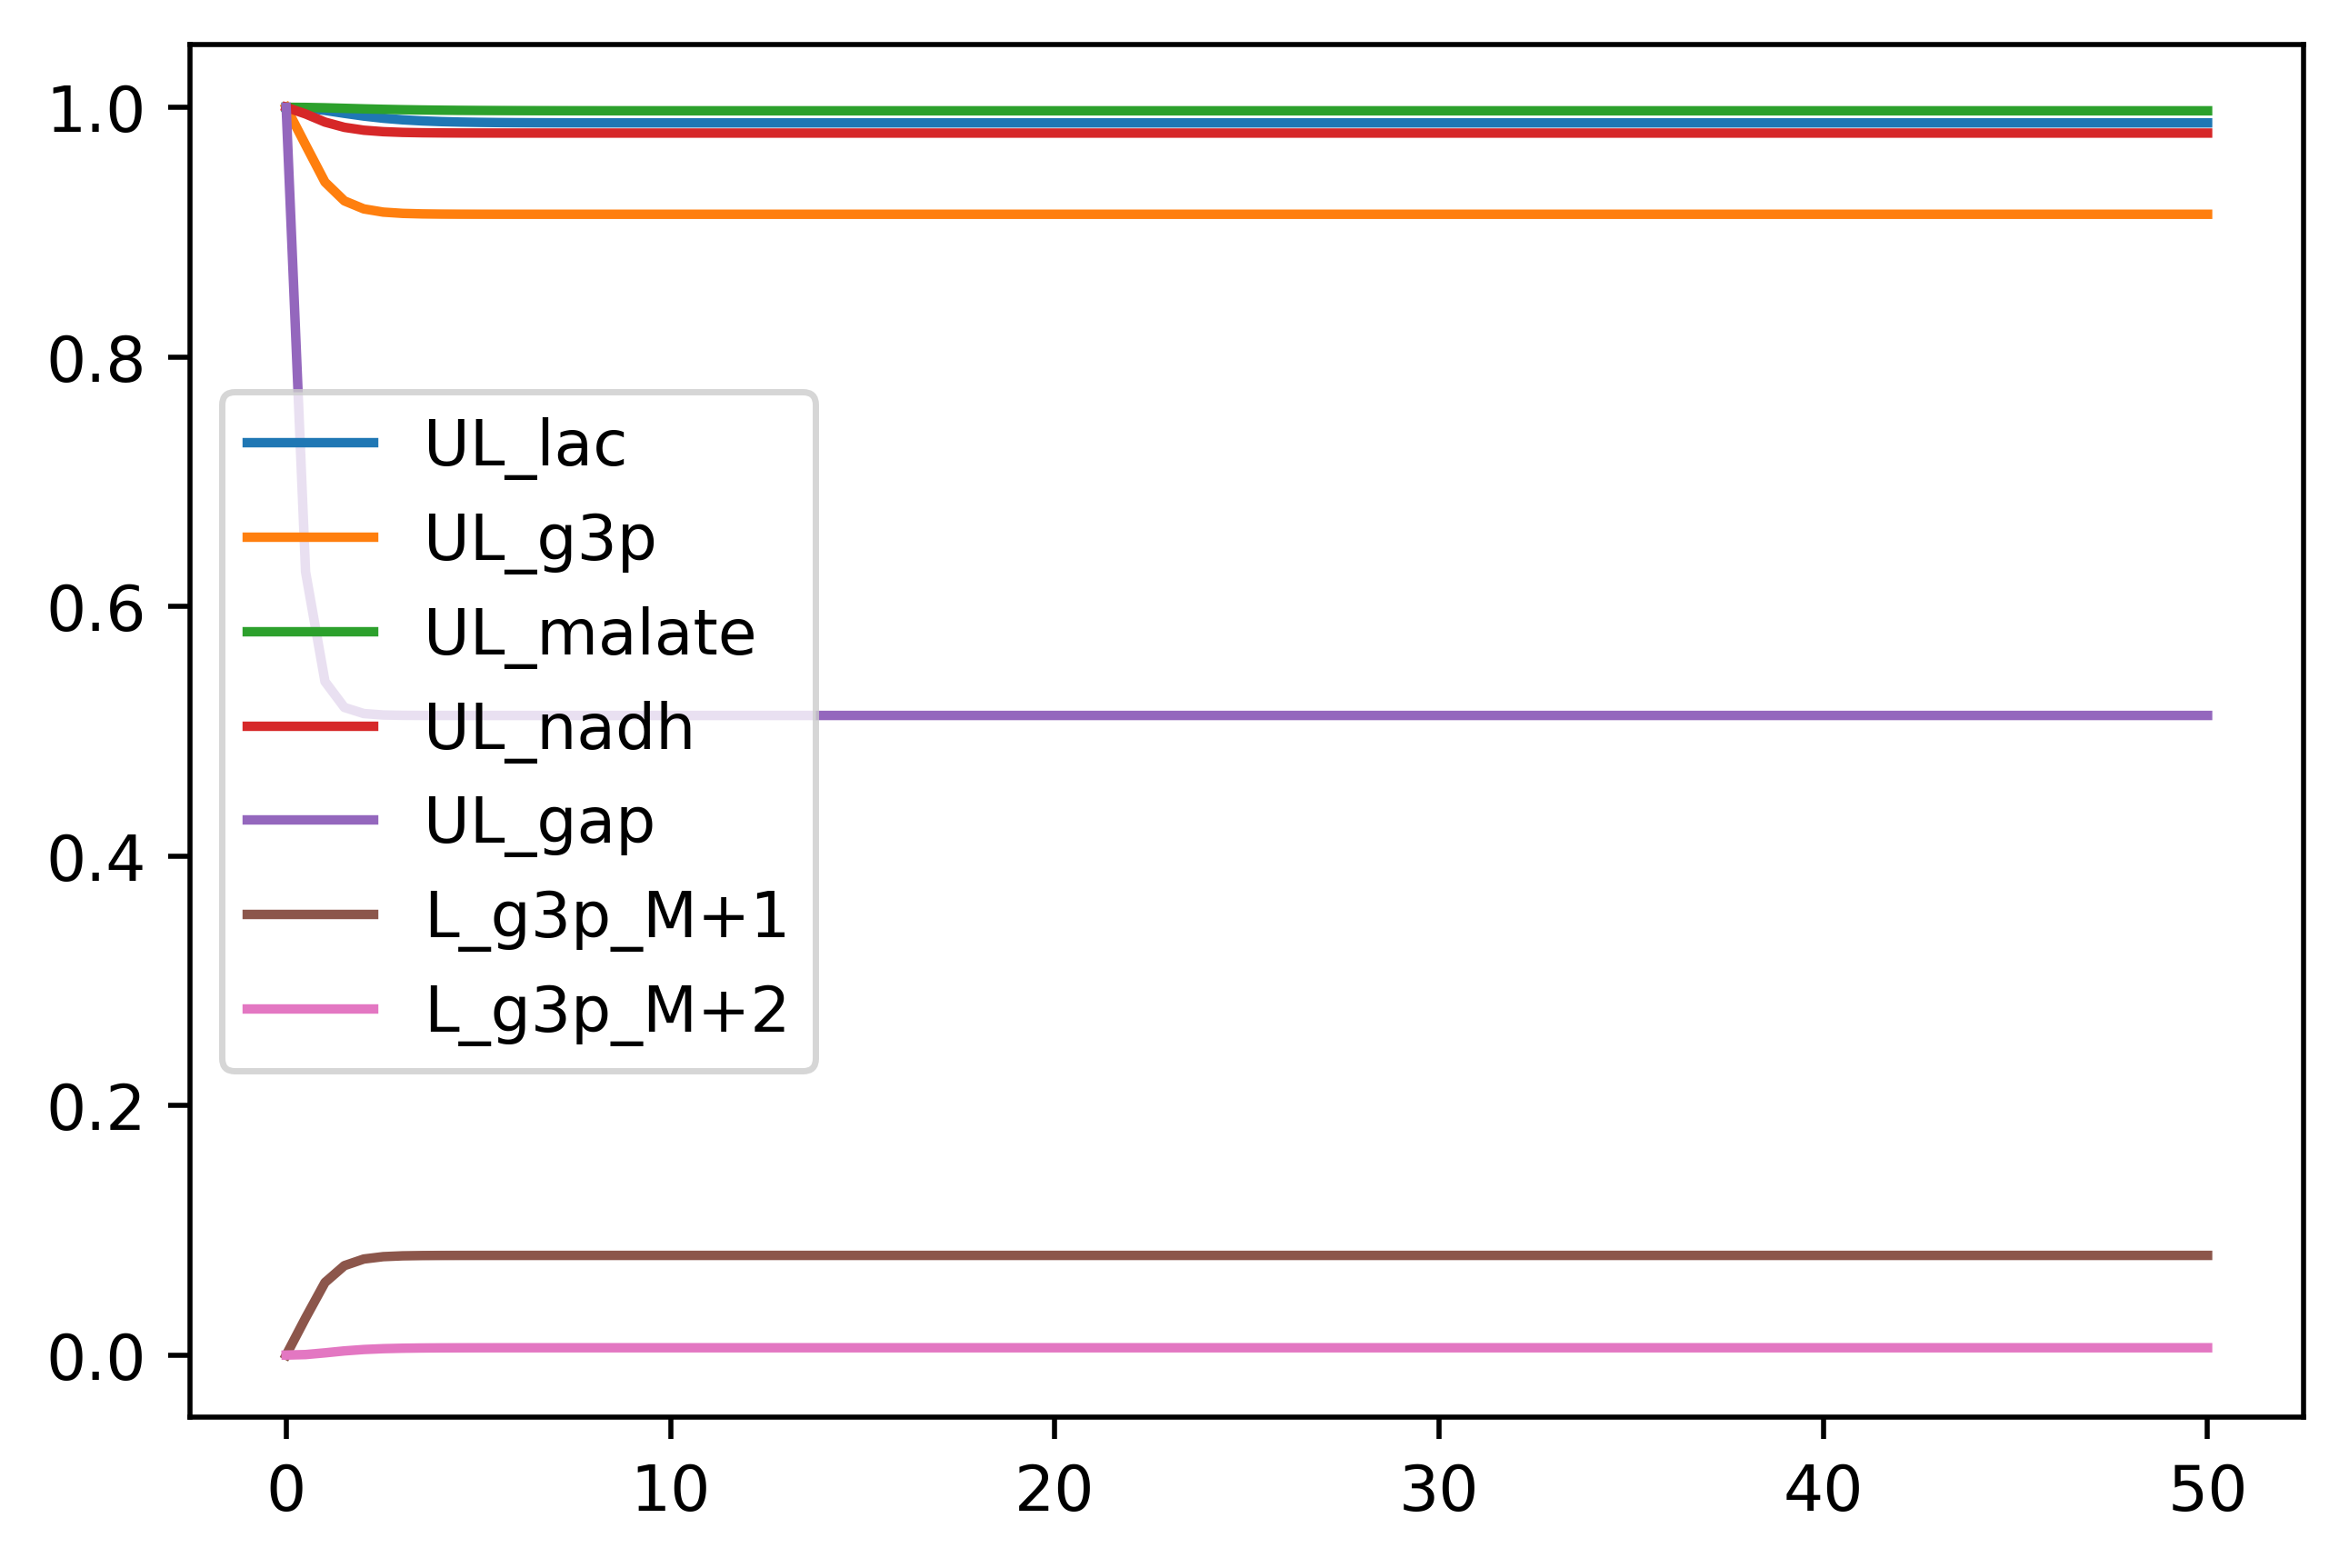

In [5]:
for col in ["UL_lac","UL_g3p","UL_malate","UL_nadh","UL_gap","L_g3p_M+1","L_g3p_M+2"]:
    plt.plot(ts,data[col],label=col)
plt.legend()
print(c0s)
print(lacE,glycolysis)
print(fluxes)
print(conc)

In [6]:
fluxes_inferred,C0s_inferred,df,conc,error = findFlux(data, ts, conc, lacE, glycolysis,vhvds, np.array([0,0,0,0]))
print(fluxes_inferred)
print(C0s_inferred)
print(conc)
print(error)
print(vhvds)
df

[0.2815    0.049375  0.4091875 0.0593125]
[ 0.44495763  0.81972866  0.57450784 22.58237405]
{'Lactate': 0.41543095304490785, 'G3P': 0.02898165938687125, 'Malate': 0.9820274845981977, 'NADH': 1.0}
[1.49610616e-11 8.74449106e-12 4.22010741e-13 1.20534115e-10]
{'vhvd_nadh_ldh': 1.1461652571800935, 'vhvd_nadh_mas': 4.709590608729503, 'vhvd_nadh_g3ps': 2.5176584703924934, 'vhvd_dhap_g3ps': 4.289411807437541, 'vhvd_nadh_dhap_g3ps': 1.1880142794414201, 'vhvd_gap_gapdh': 1.0}


,UL_lac,UL_g3p,UL_malate,UL_nadh,UL_gap,L_lac,L_malate,L_nadh,L_gap,L_g3p_M+1,L_g3p_M+2,L_g3p
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.999315,0.969859,0.999892,0.994625,0.627693,0.000685,0.000108,0.005375,0.372307,0.029742,0.000401,0.030141
2,0.997481,0.940054,0.999586,0.988080,0.539783,0.002519,0.000414,0.011920,0.460217,0.058162,0.001782,0.059946
3,0.995126,0.924985,0.999165,0.983933,0.519025,0.004874,0.000835,0.016067,0.480975,0.071675,0.003338,0.075015
4,0.992950,0.918571,0.998742,0.981669,0.514124,0.007050,0.001258,0.018331,0.485876,0.076974,0.004463,0.081429
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.987498,0.914253,0.997184,0.979332,0.512609,0.012502,0.002816,0.020668,0.487391,0.079882,0.005865,0.085747
96,0.987498,0.914253,0.997184,0.979332,0.512609,0.012502,0.002816,0.020668,0.487391,0.079882,0.005865,0.085747
97,0.987498,0.914253,0.997184,0.979332,0.512609,0.012502,0.002816,0.020668,0.487391,0.079882,0.005865,0.085747
98,0.987498,0.914253,0.997184,0.979332,0.512609,0.012502,0.002816,0.020668,0.487391,0.079882,0.005865,0.085747


In [7]:
dhap_params = fitSource(ts, data["UL_gap"])
dhap = lambda x: exponetialCurve(x,dhap_params)

    
firstT = np.min(ts)
firstT = [x for x in range(len(ts)) if abs(firstT-ts[x]) < 1e-5]
initialState = [np.mean(data.loc[firstT,label])*c for label,c in zip(["UL_lac","UL_g3p","UL_malate","UL_nadh"],[conc["Lactate"],conc["G3P"],conc["Malate"],conc["NADH"]])]


nadh = interp1d(ts,
                integrateModel(nadhEquation,ts,(fluxes_inferred[3],conc['NADH'],C0s_inferred[3] * fluxes_inferred[3],None,dhap,vhvds),initialState[3],conc["NADH"])[:,0],
                bounds_error=False,fill_value="extrapolate") 


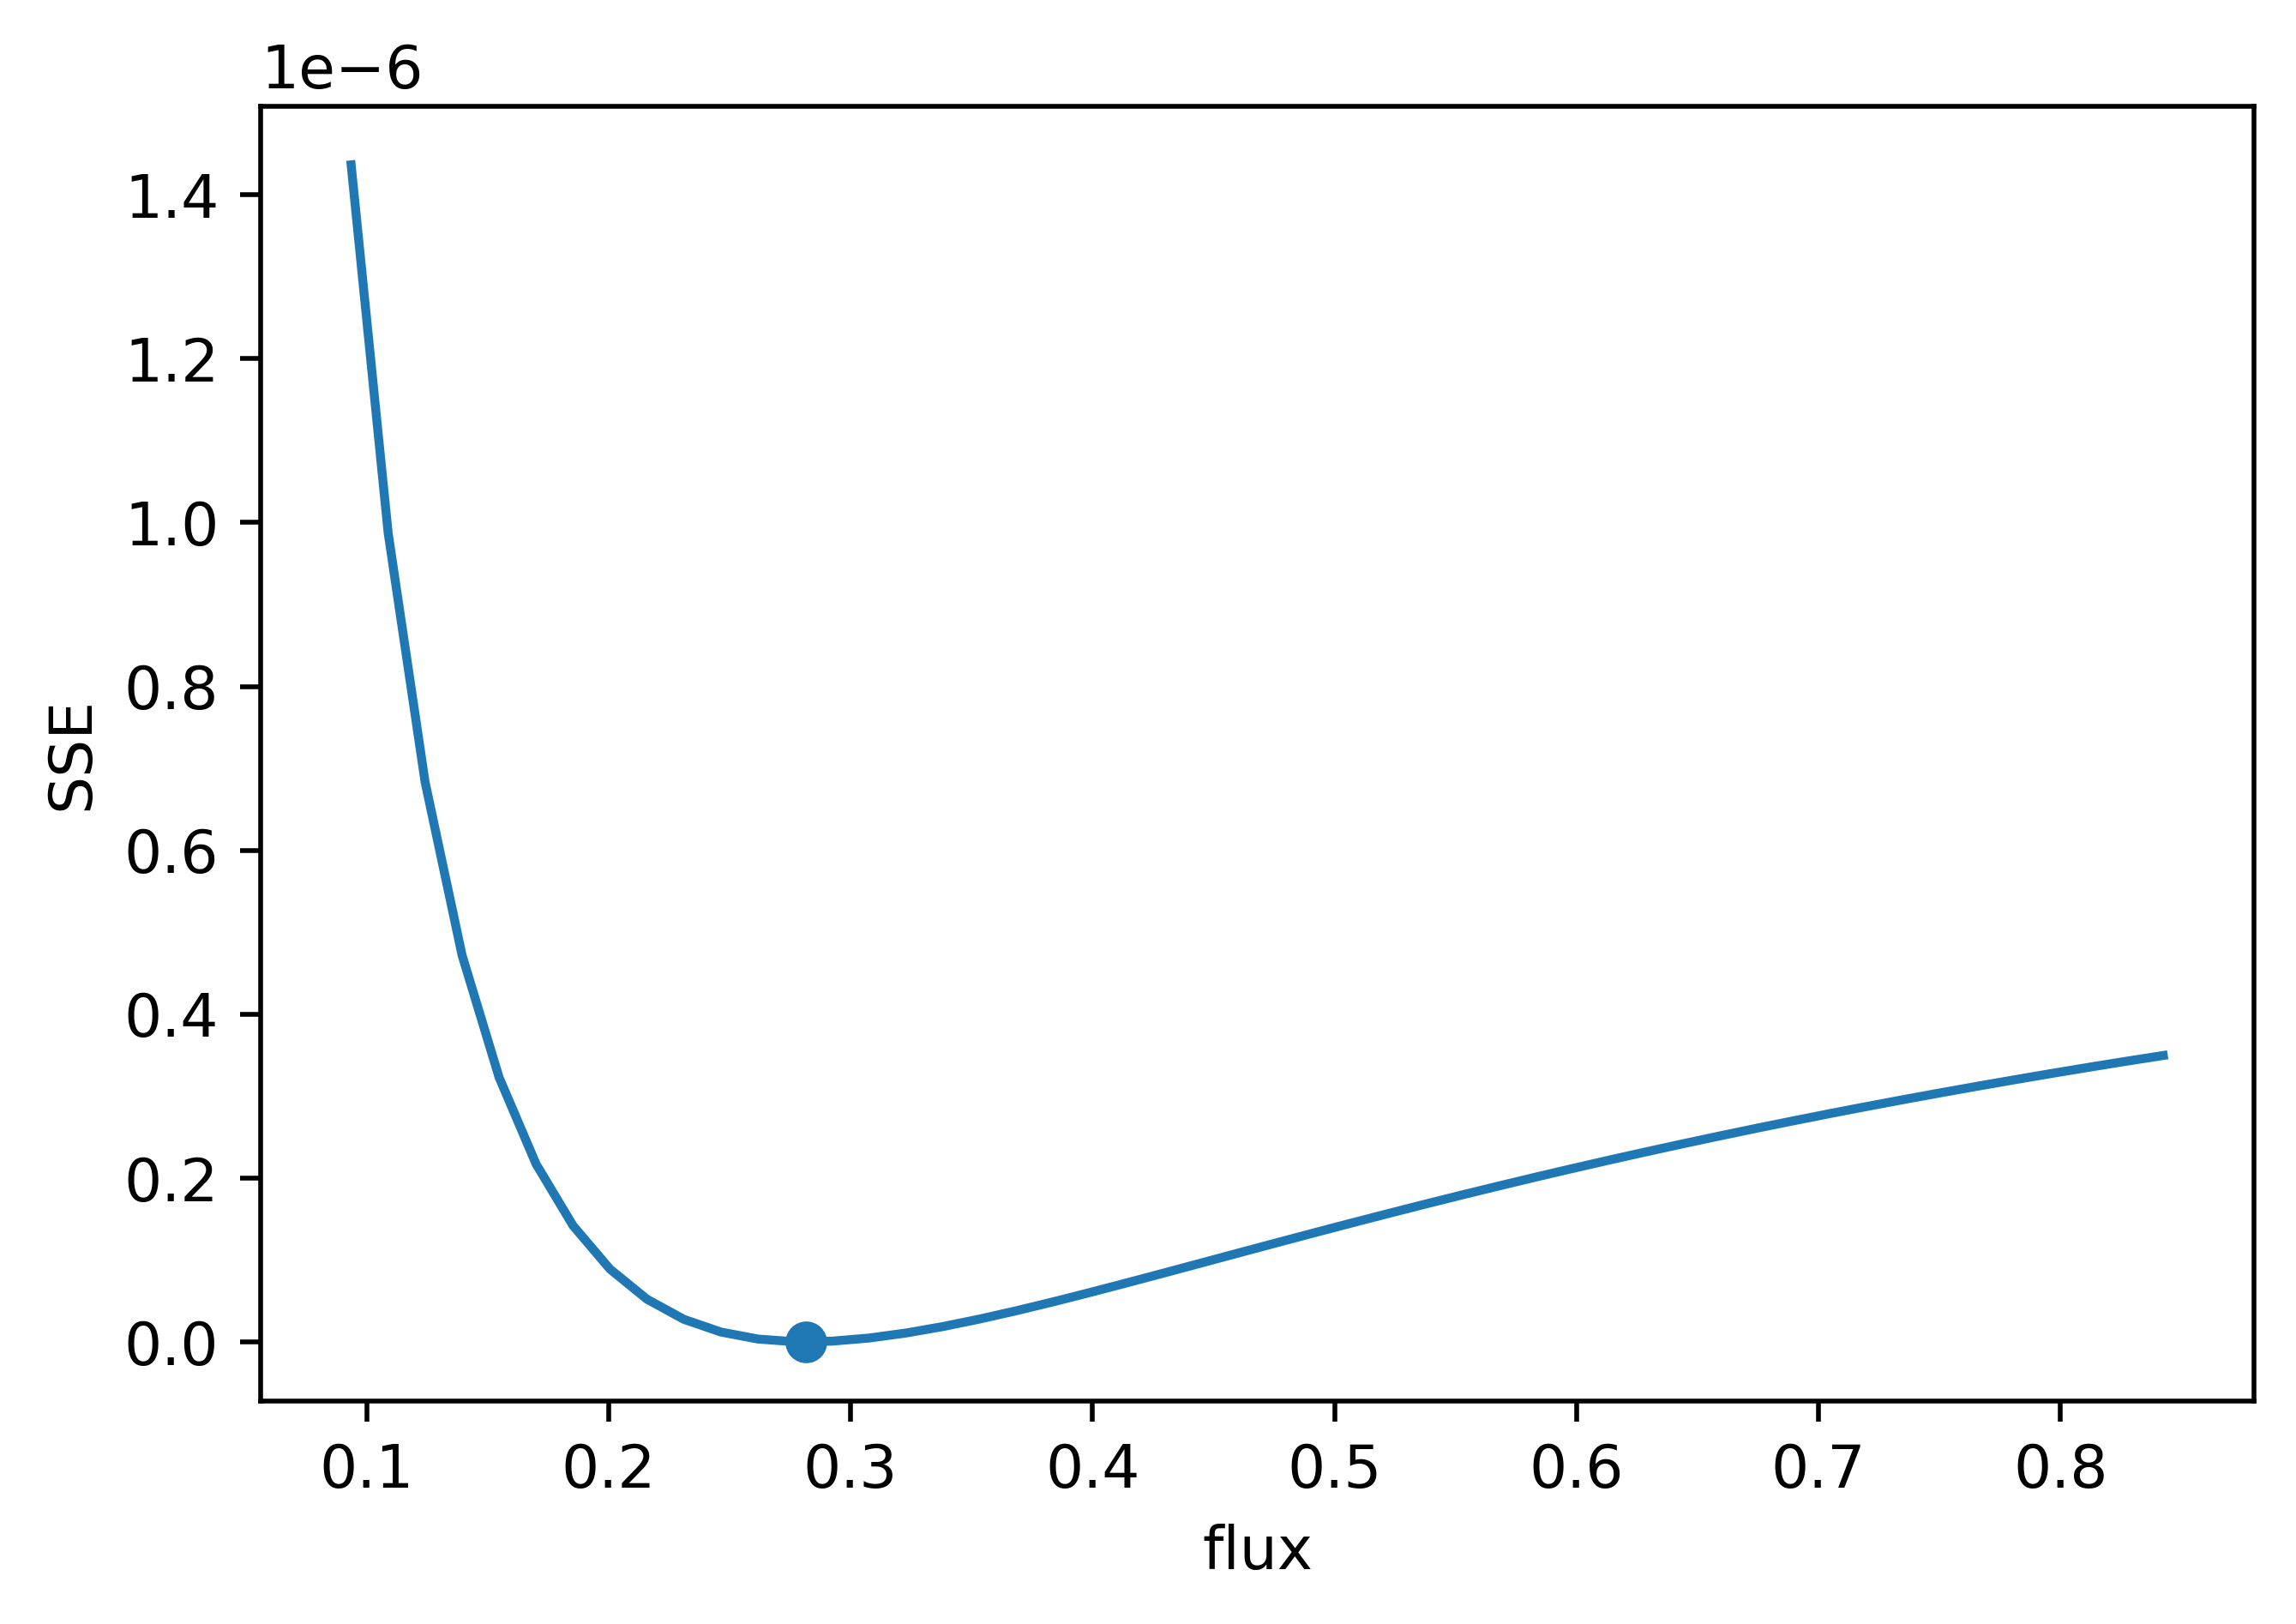

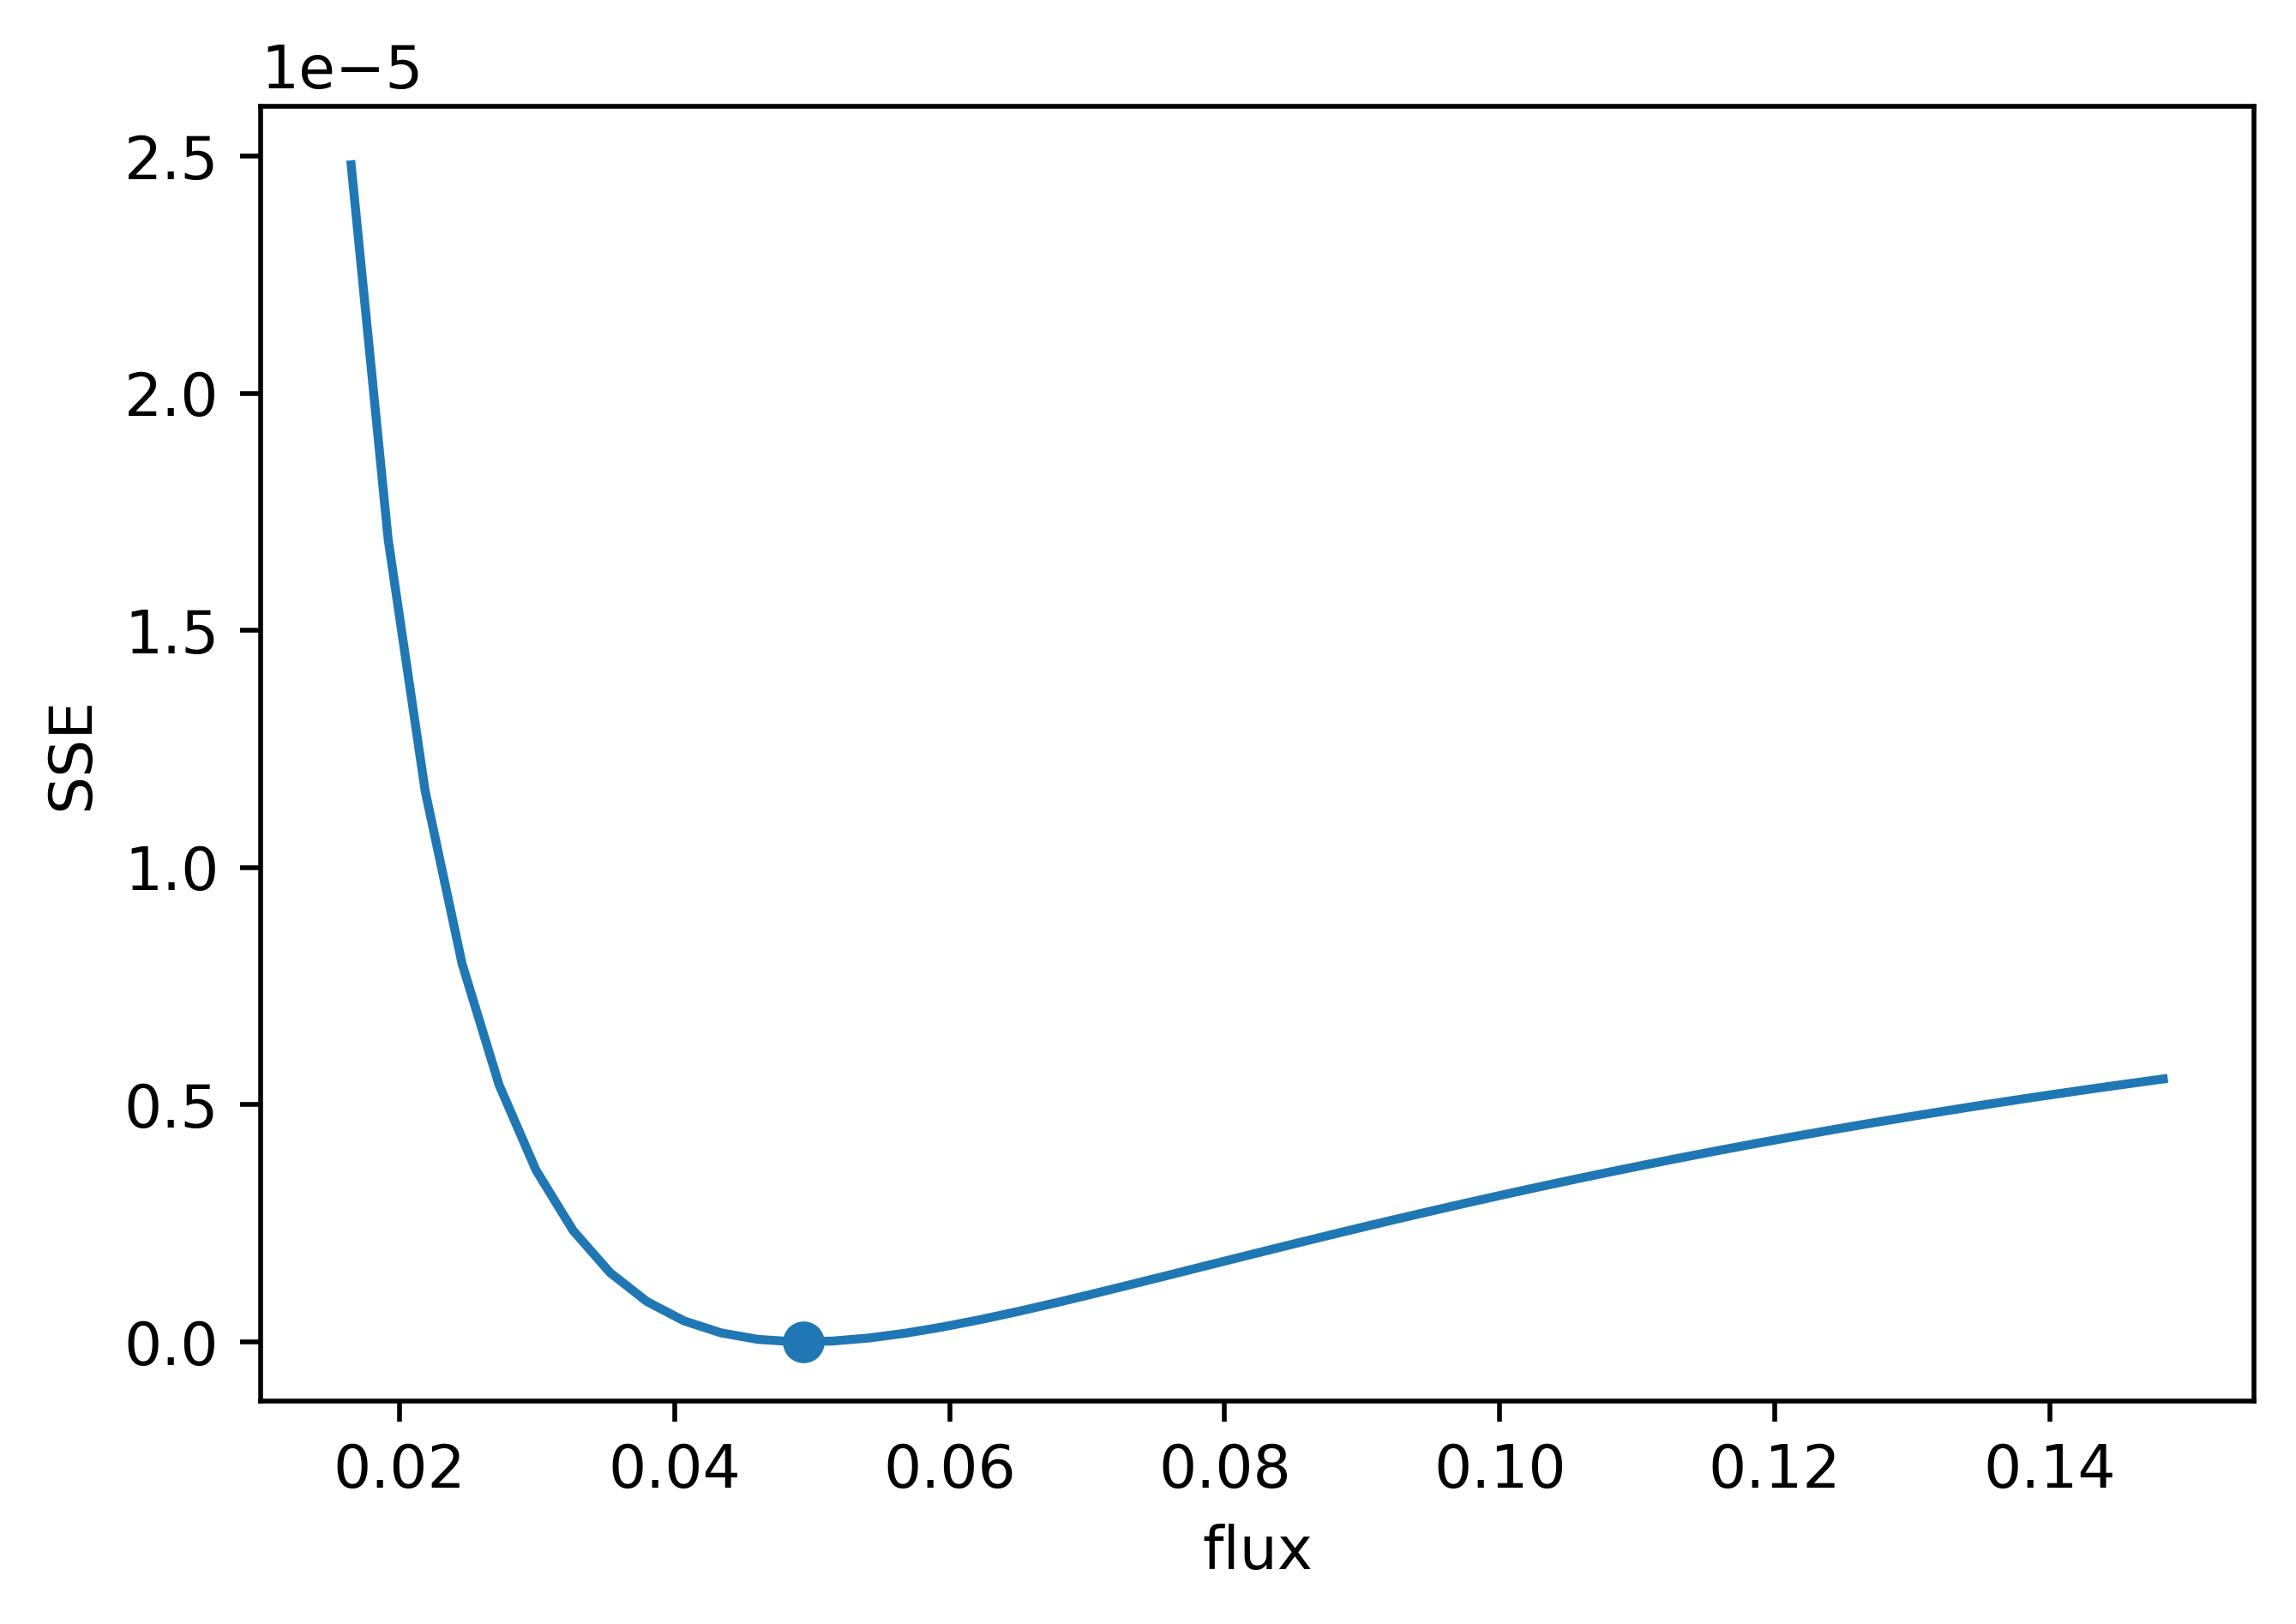

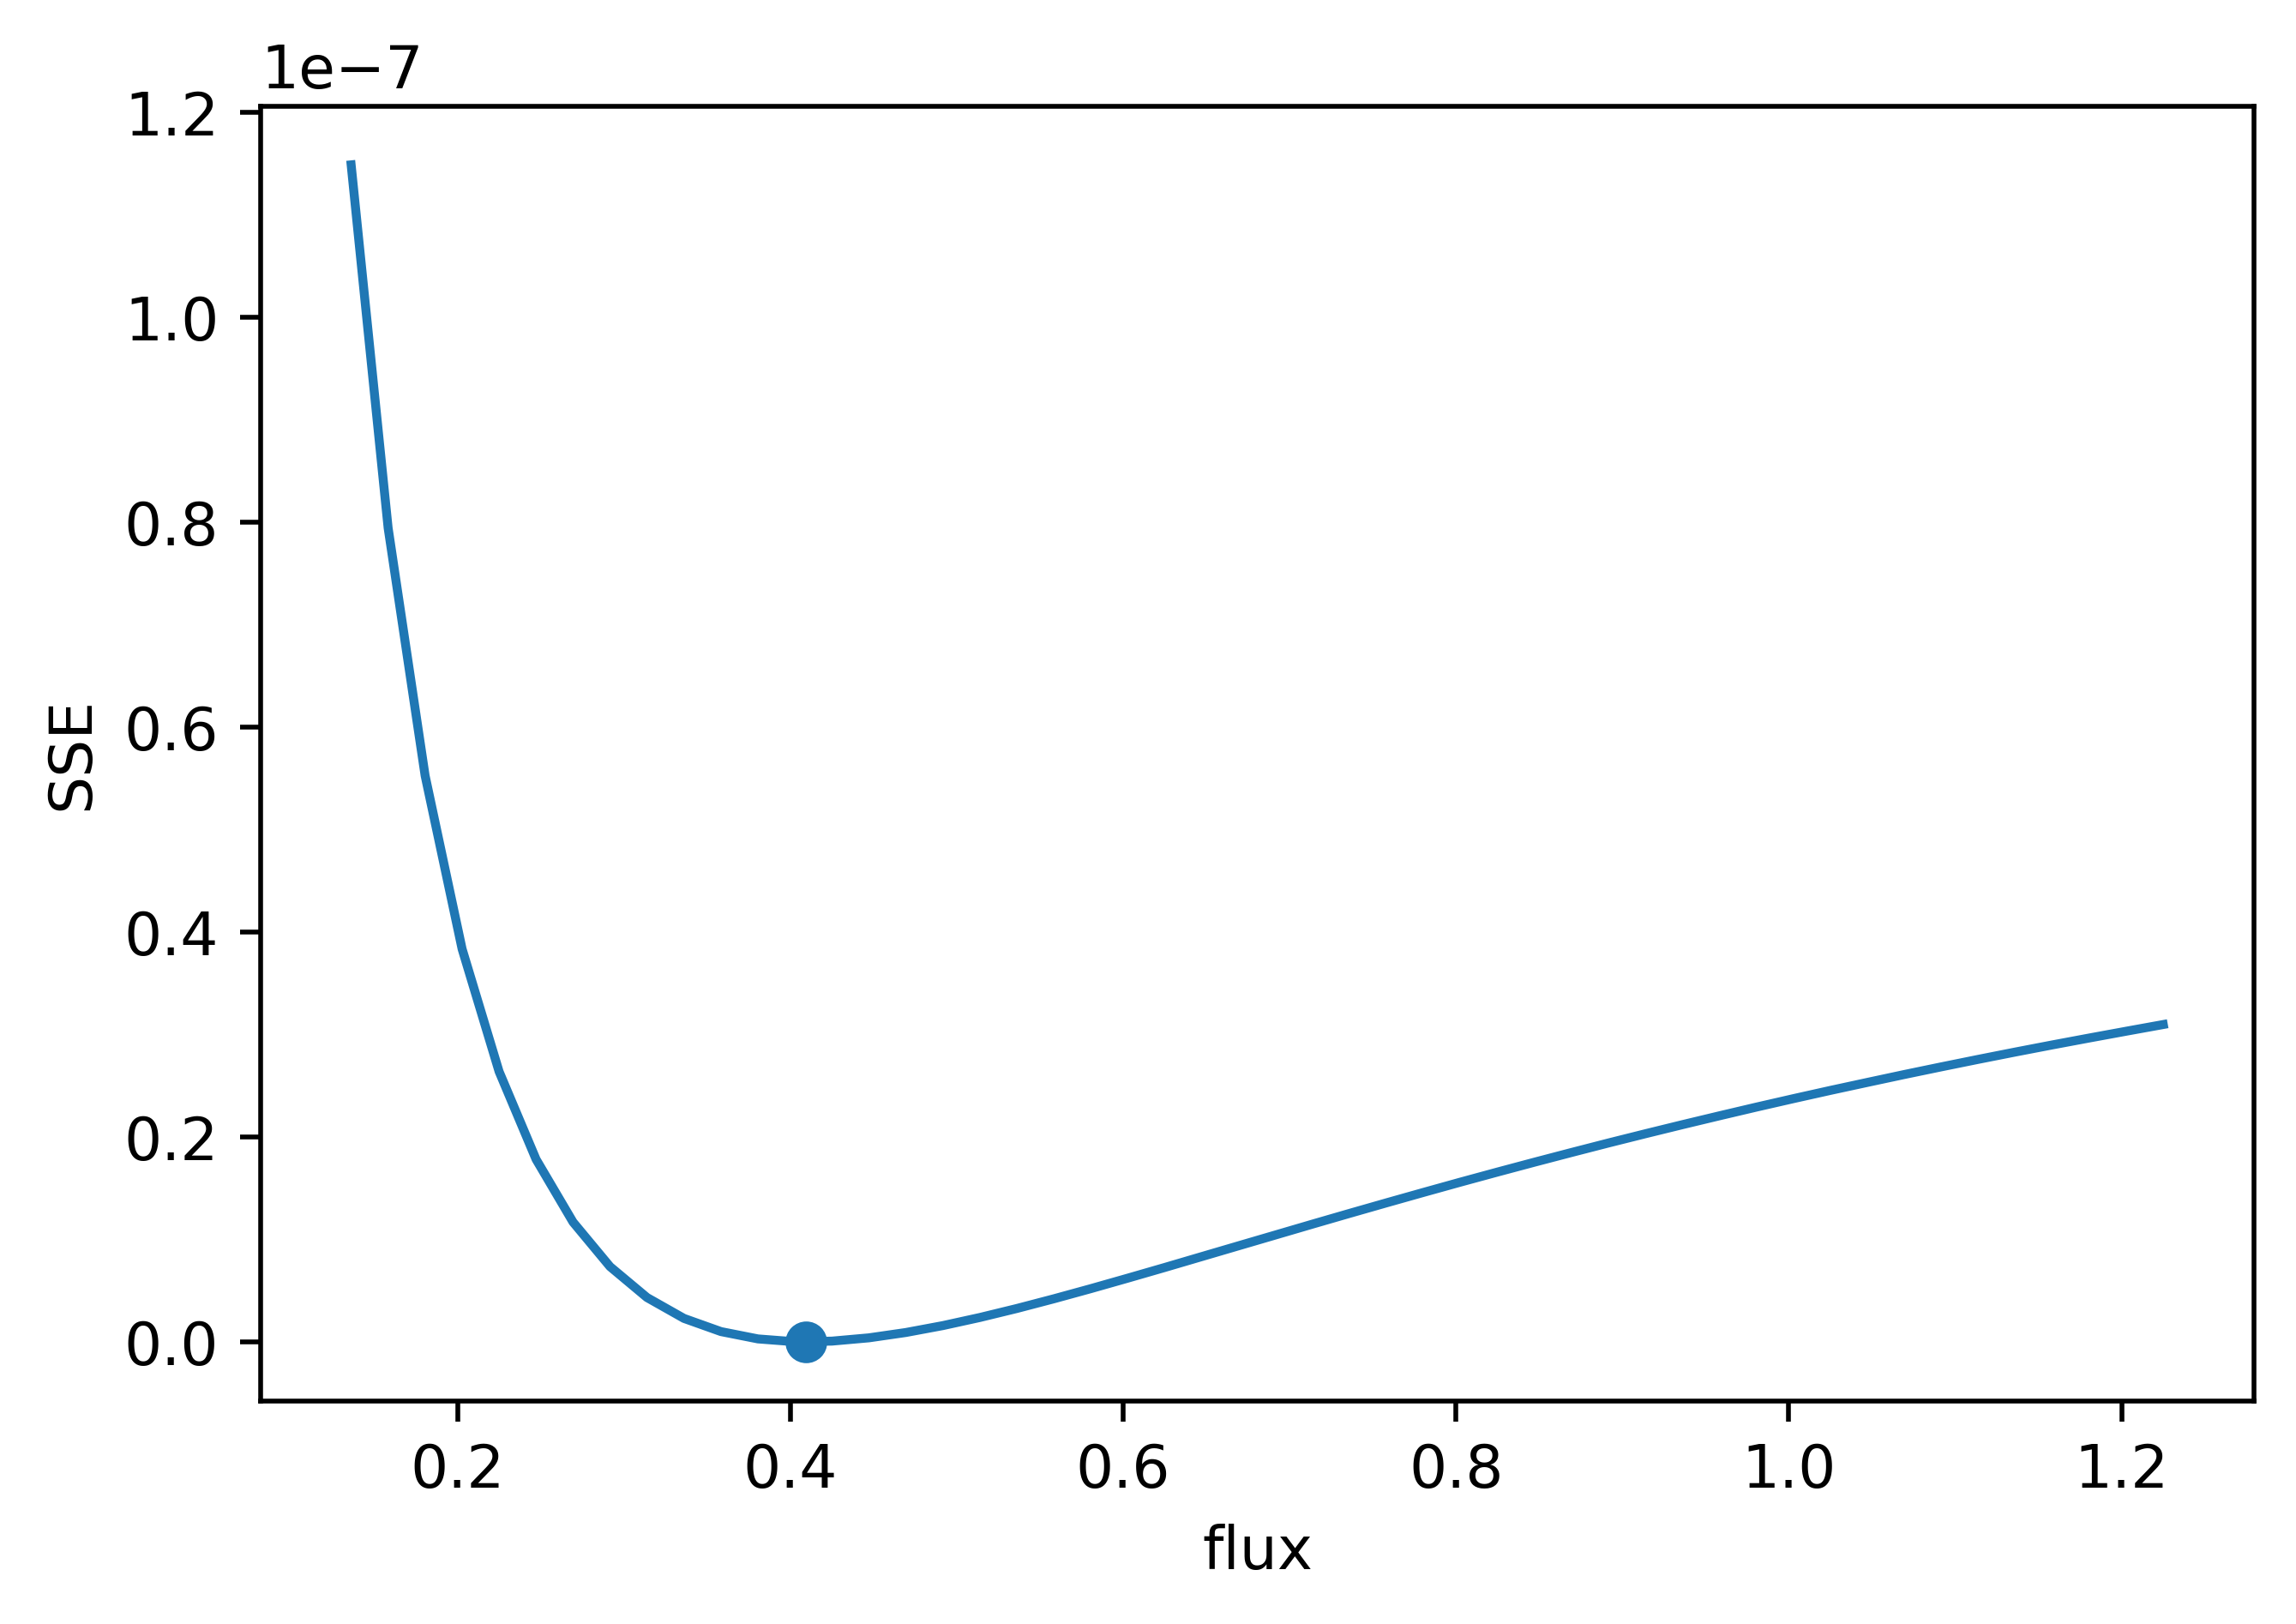

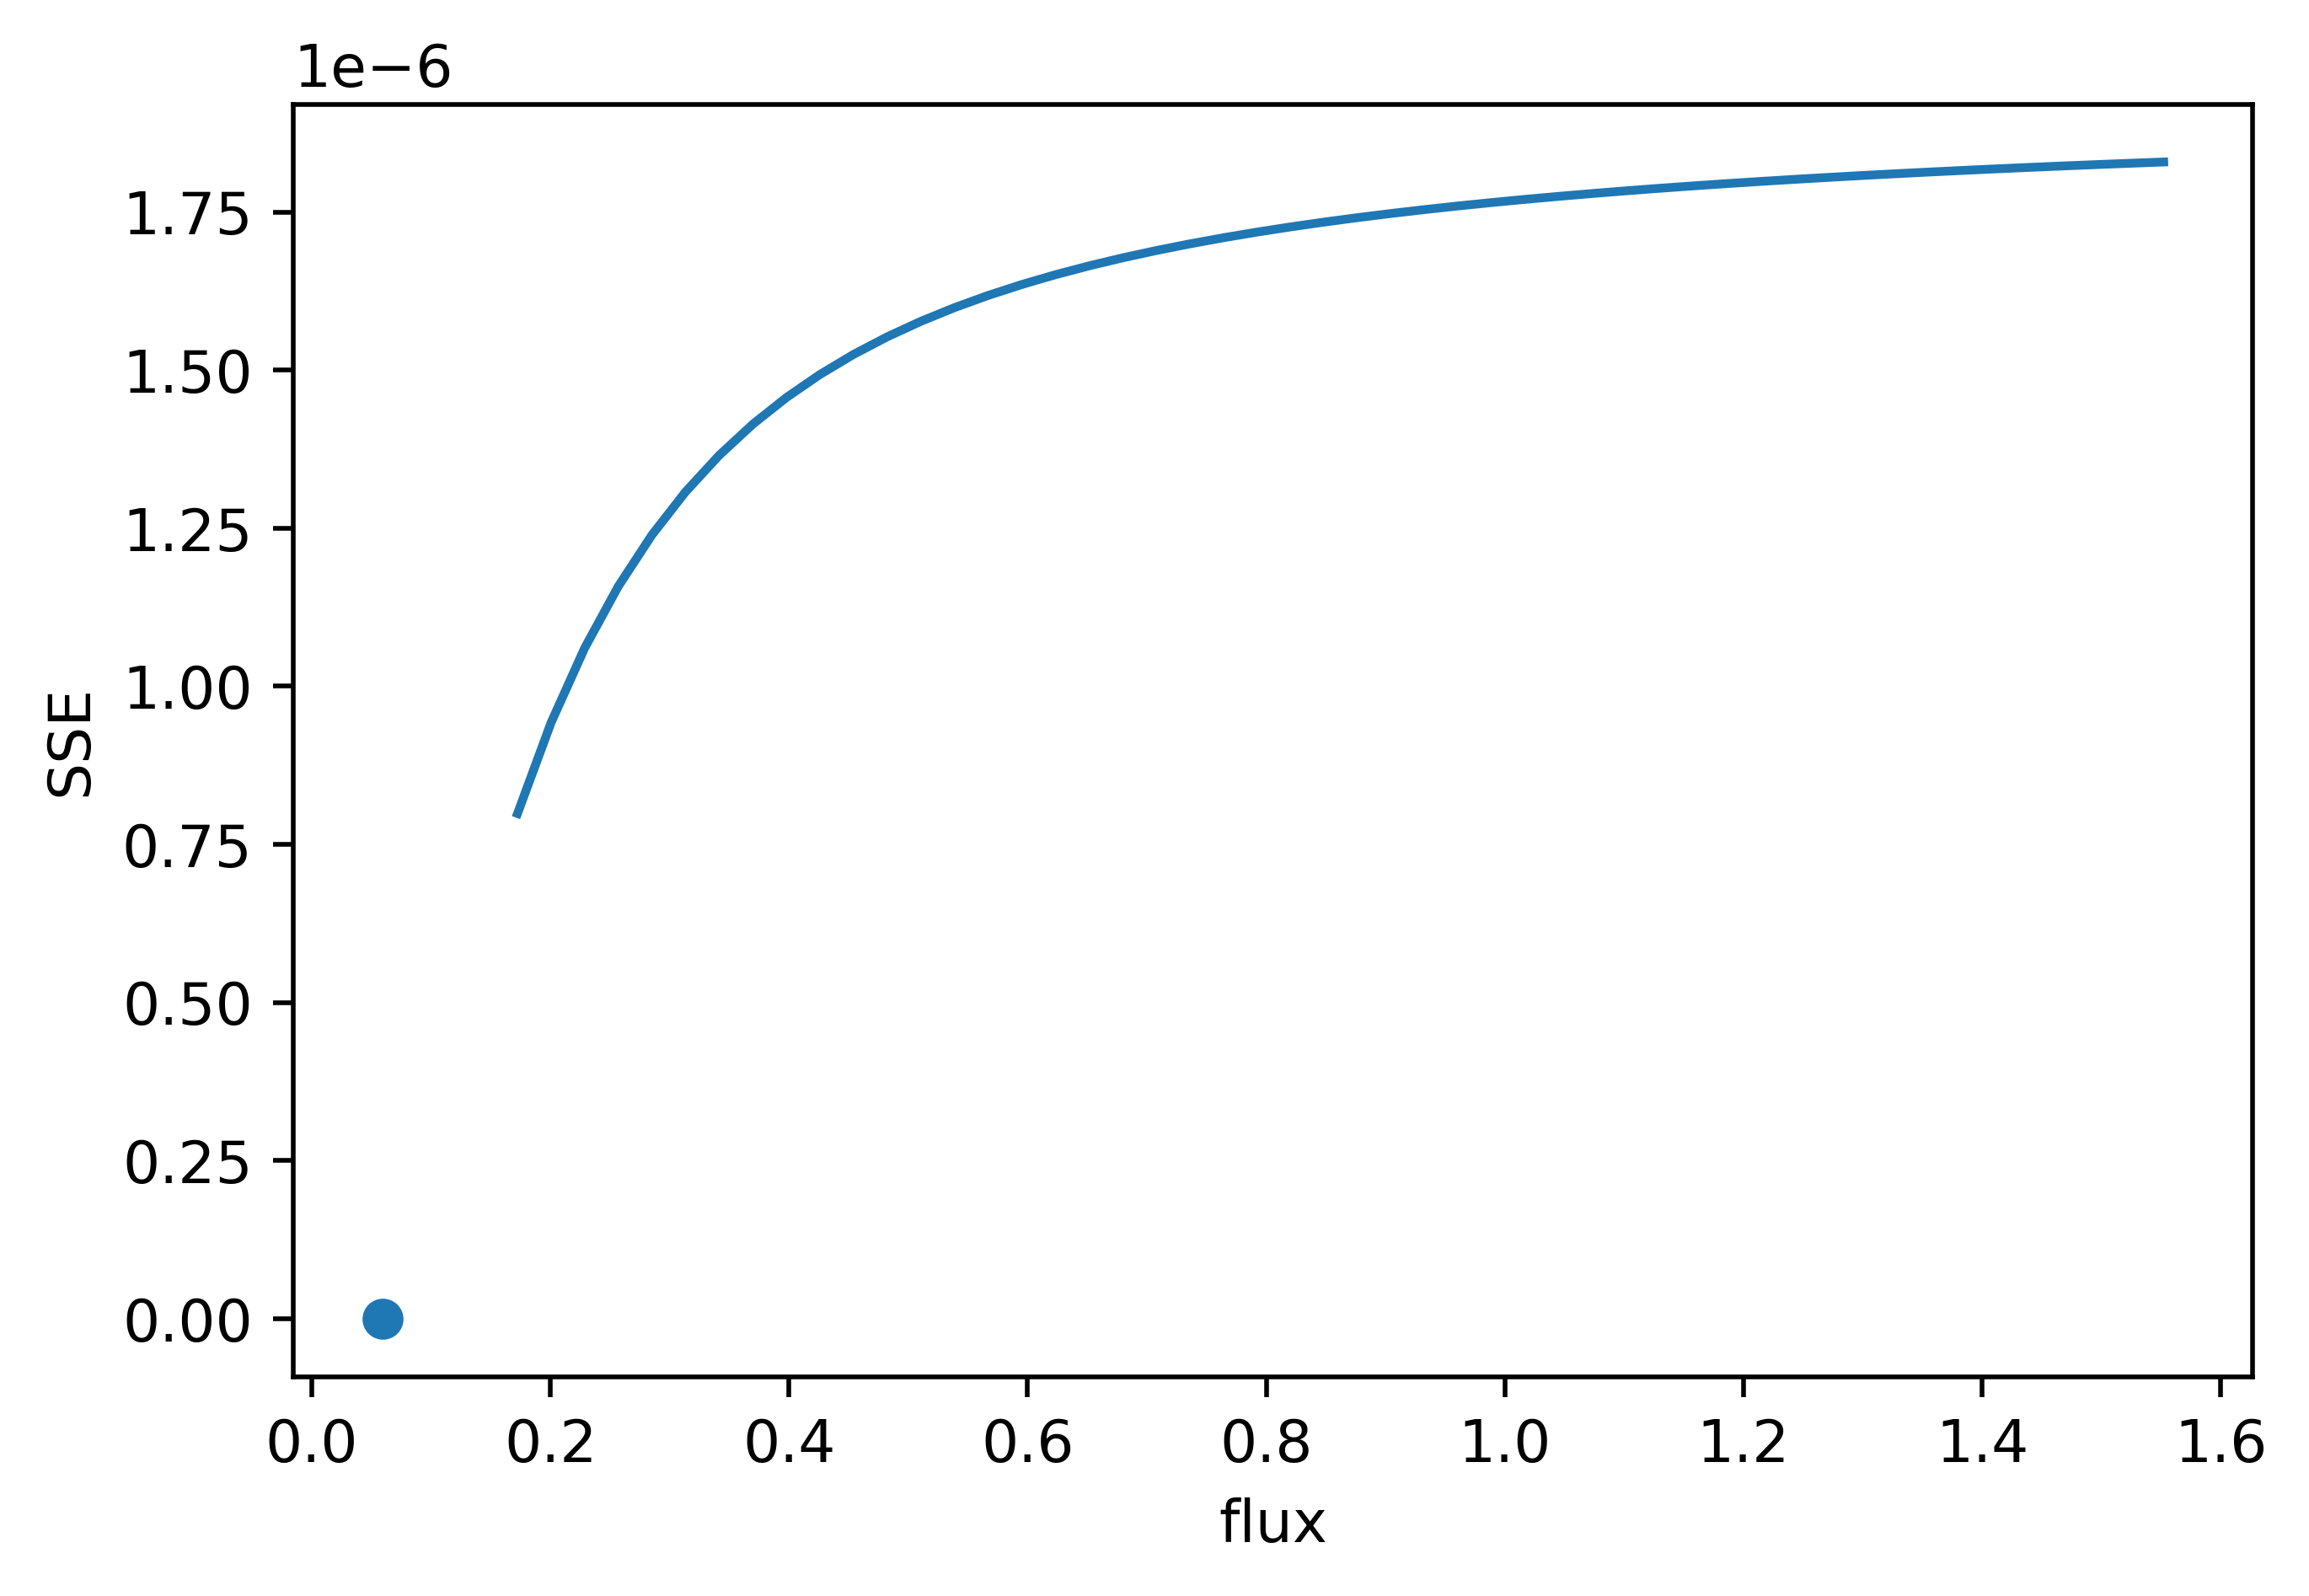

In [8]:
equations = [lactateEquation,g3pEquation,malateEquation,nadhEquation]
labels1 = ["UL_lac","UL_g3p","UL_malate","UL_nadh"]
labels2 = ["Lactate","G3P","Malate","NADH"]
for x in range(4):
    fluxes_to_try = np.linspace(fluxes[x]/3,3*fluxes[x])
    #fluxes_to_try = np.linspace(0,2*fluxes_inferred[x])
    errs = []
    for f in fluxes_to_try:
        val = integrateModel(equations[x],ts,(f,conc[labels2[x]],C0s_inferred[x] * f,nadh,dhap,vhvds),initialState[x],conc[labels2[x]])[:,0]
        err = sse(val,data[labels1[x]].values)#np.sum(np.abs(val-data["UL_nadh"].values))
        errs.append(err)
    f = fluxes_inferred[x]
    val = integrateModel(equations[x],ts,(f,conc[labels2[x]],C0s_inferred[x] * f,nadh,dhap,vhvds),initialState[x],conc[labels2[x]])[:,0]
    err = sse(val,data[labels1[x]].values)
    plt.figure()
    plt.plot(fluxes_to_try,errs)
    plt.ylabel("SSE")
    plt.xlabel("flux")
    plt.scatter([f],[err])
#plt.xlim((0,20000))

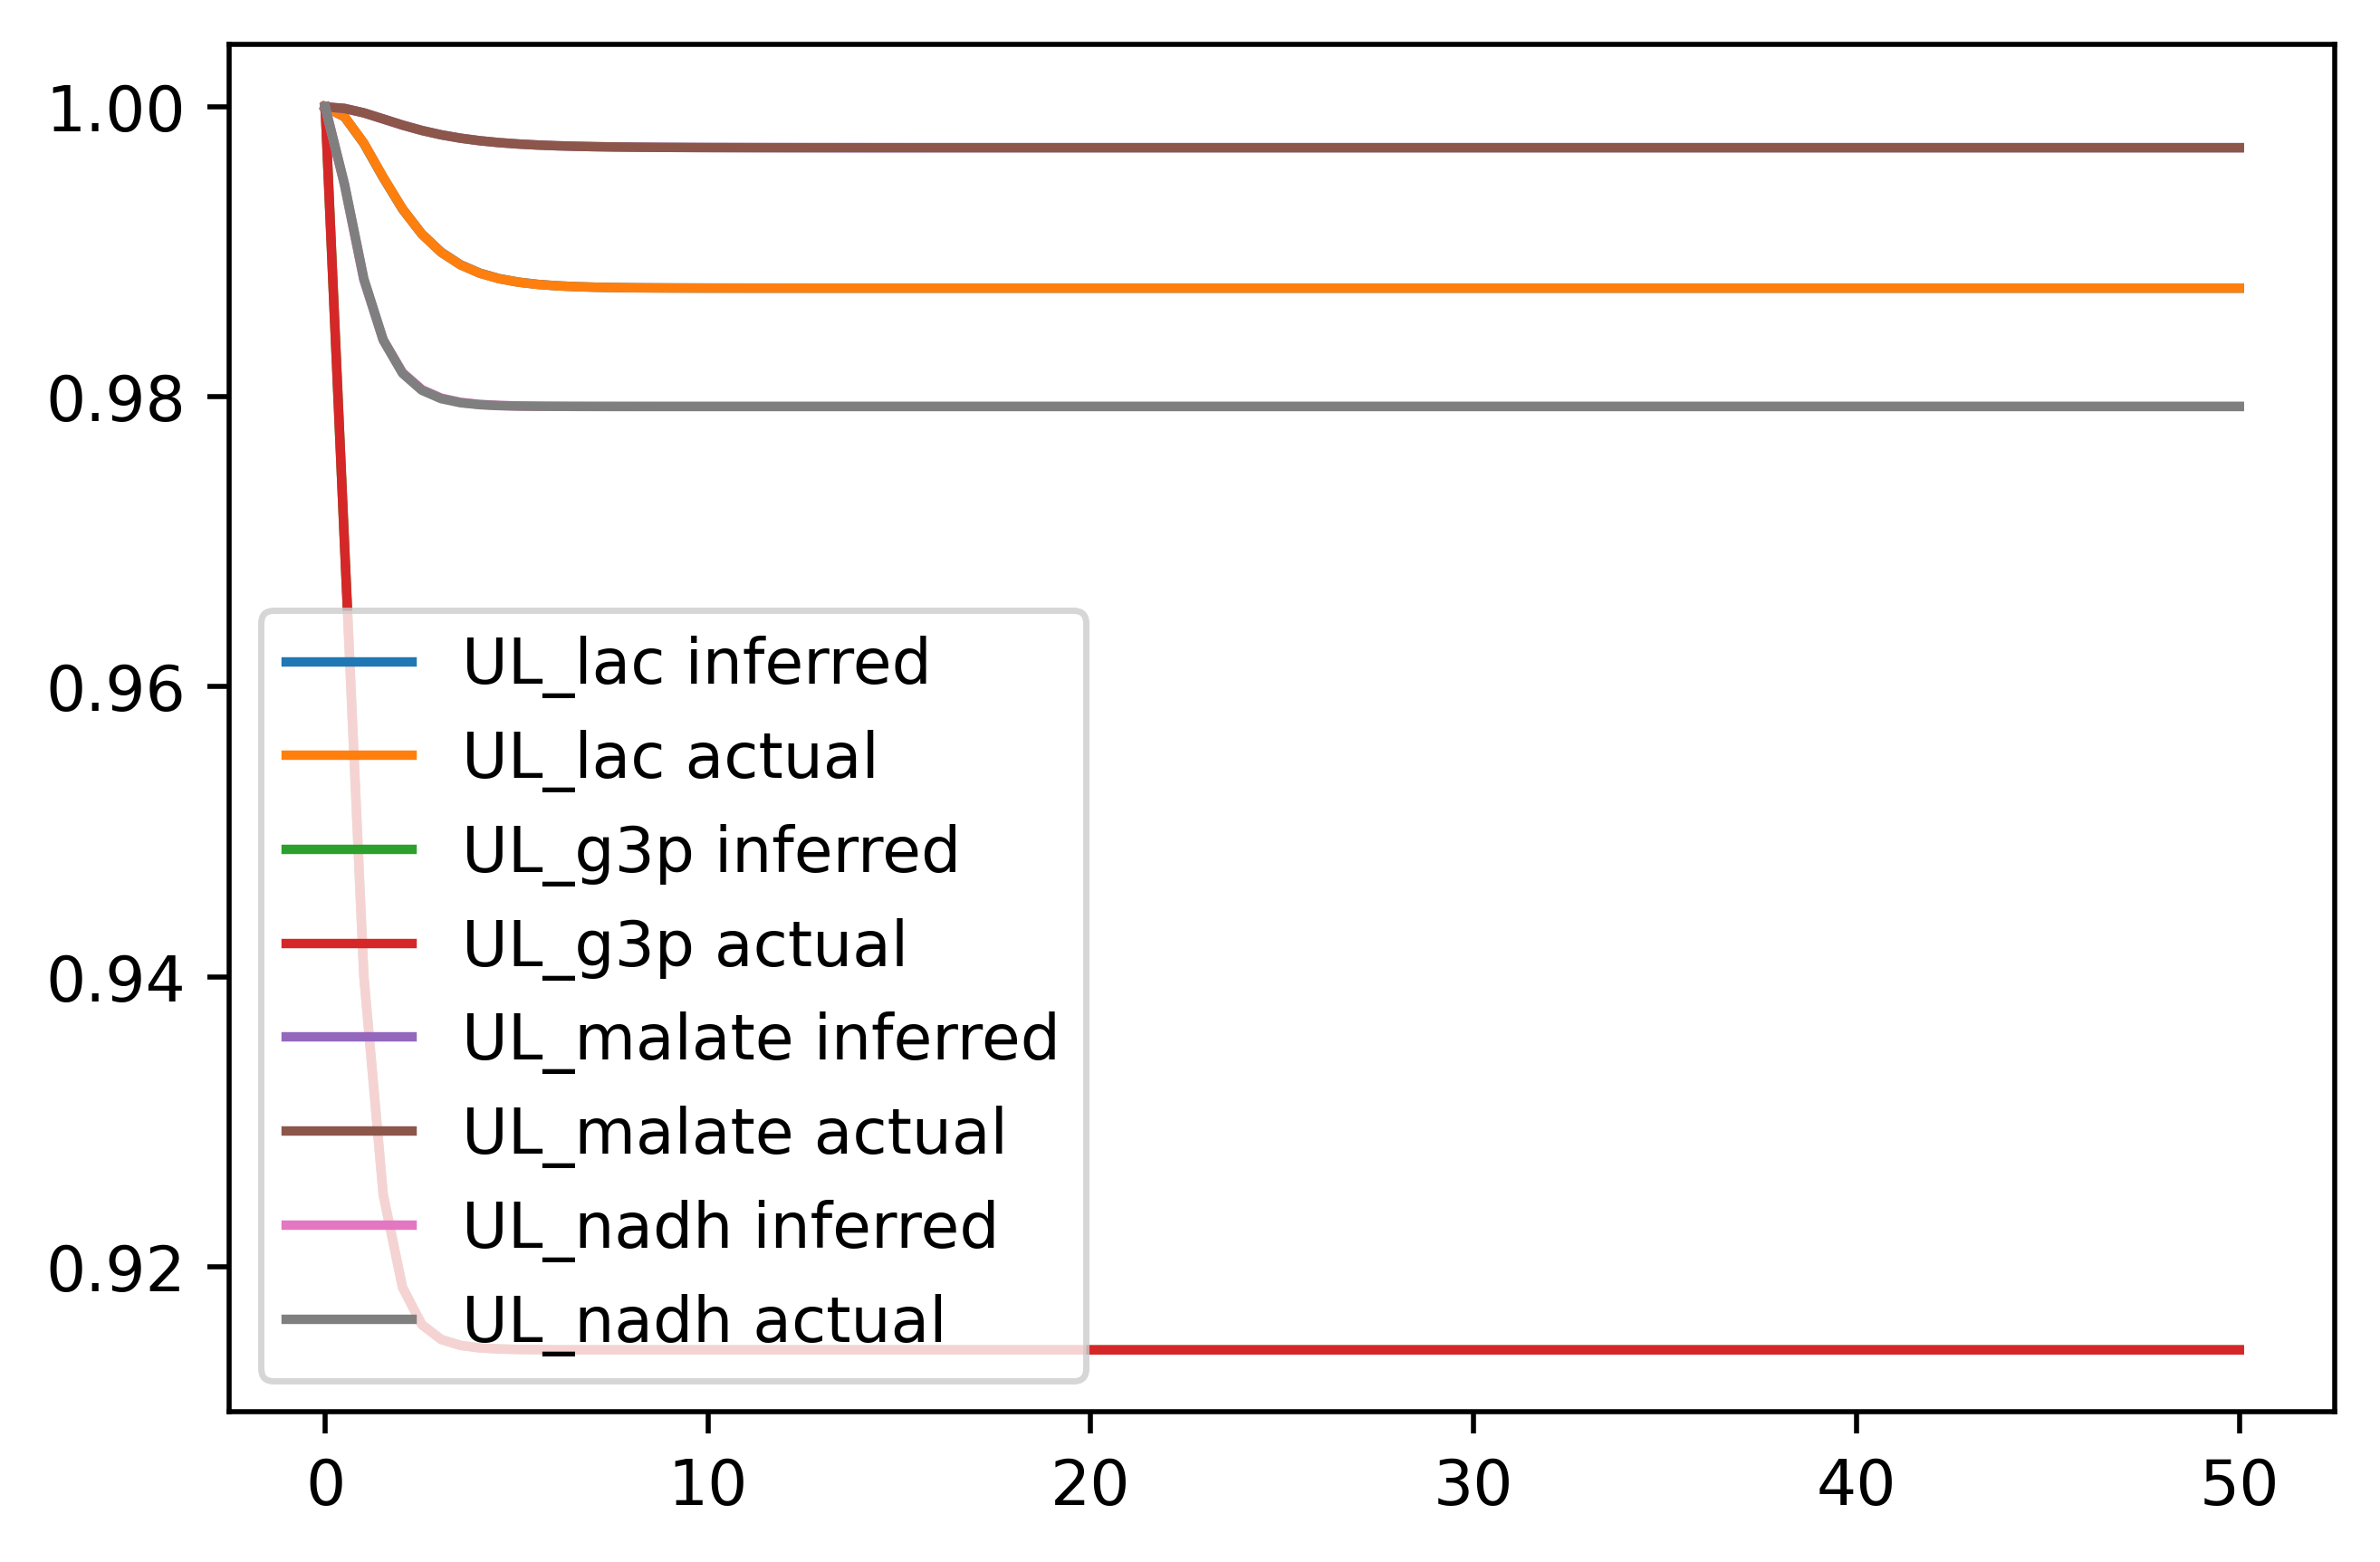

In [9]:
values = integrateLabelingModel(ts, fluxes_inferred,conc,dhap_params,C0s_inferred,vhvds,initialState)
inferred = pd.DataFrame(data=values,columns=["UL_lac","UL_g3p","UL_malate","UL_nadh"])
for col in ["UL_lac","UL_g3p","UL_malate","UL_nadh"]:
    plt.plot(ts,inferred[col],label=col + " inferred")
    plt.plot(ts,data[col],label=col+" actual")
plt.legend()


In [10]:
if __name__ == '__main__':
    true = []
    pred = []
    err = []
    args = [[ts,numBestFitIters] for _ in range(numSims)]
    result = startConcurrentTask(simulateDataAndInferFlux,args,numCores,"running simulations",len(args))
    for fluxes,(inferred_fluxes,_,_,conc,errs) in result:
        true.append(fluxes)
        pred.append(inferred_fluxes)
        err.append(errs)
true = np.array(true)
pred = np.array(pred)
err = np.array(err)

running simulations |██████████████████████████████████████████████████| 100.0% 


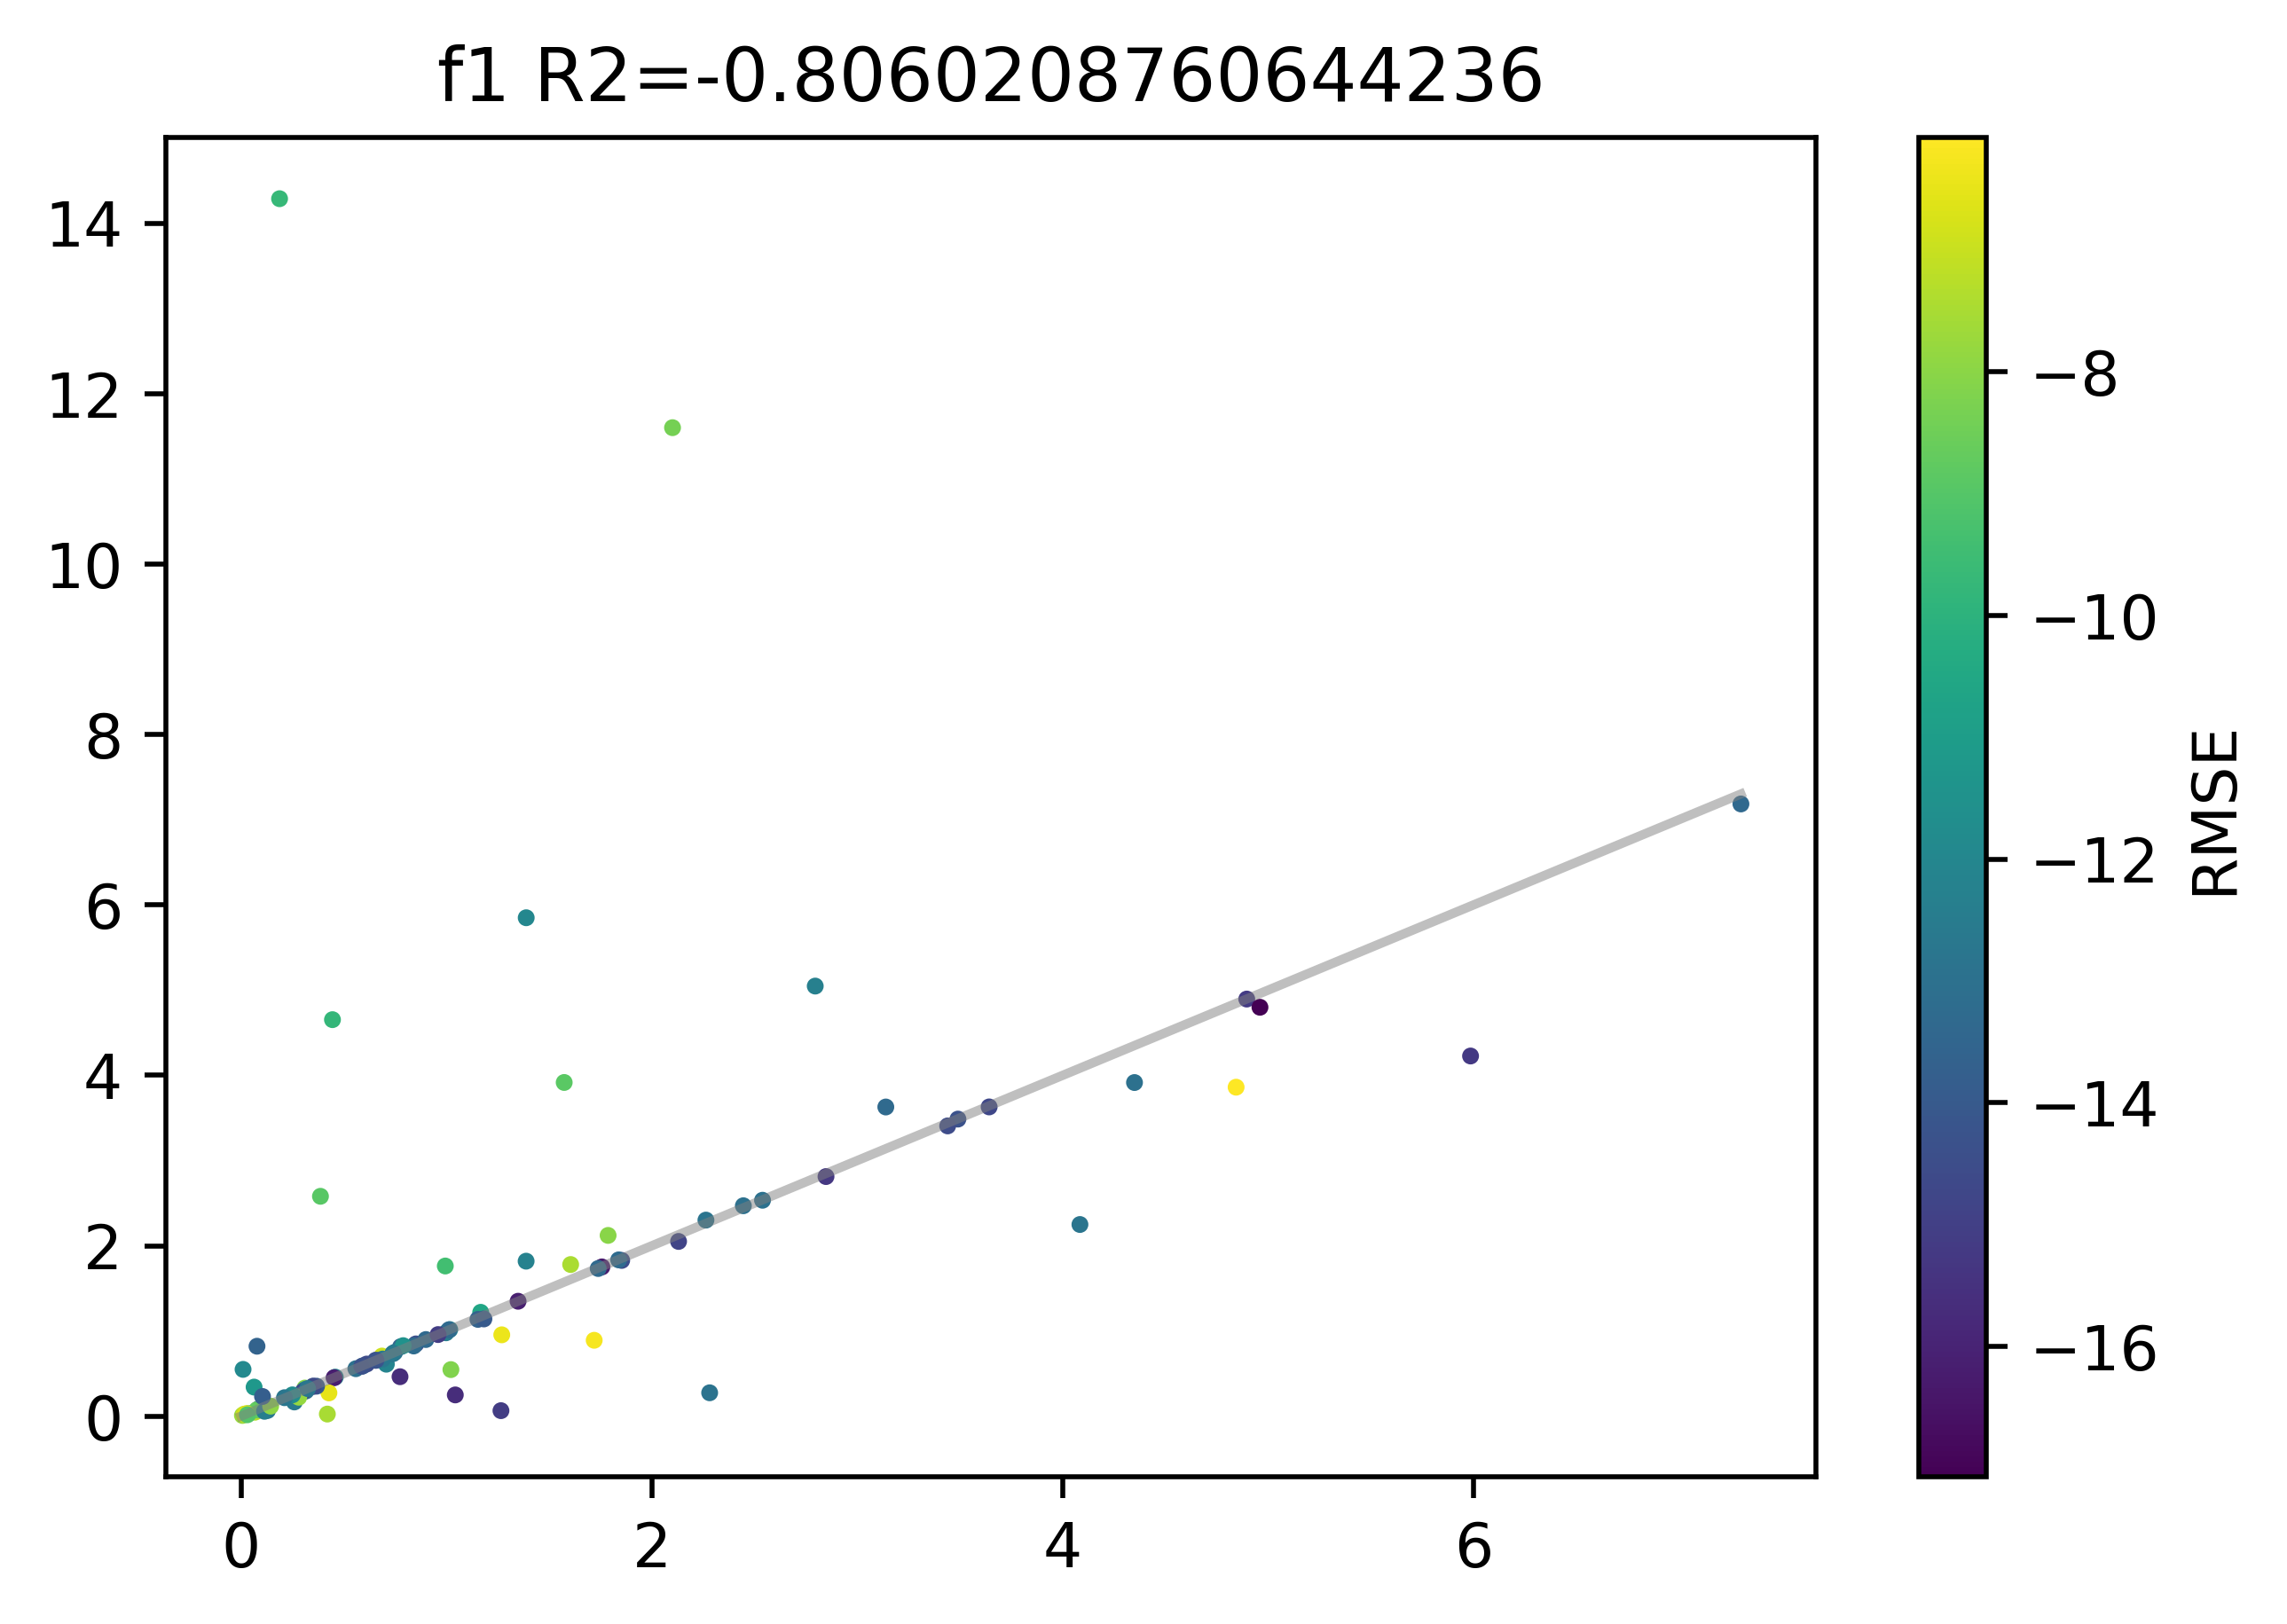

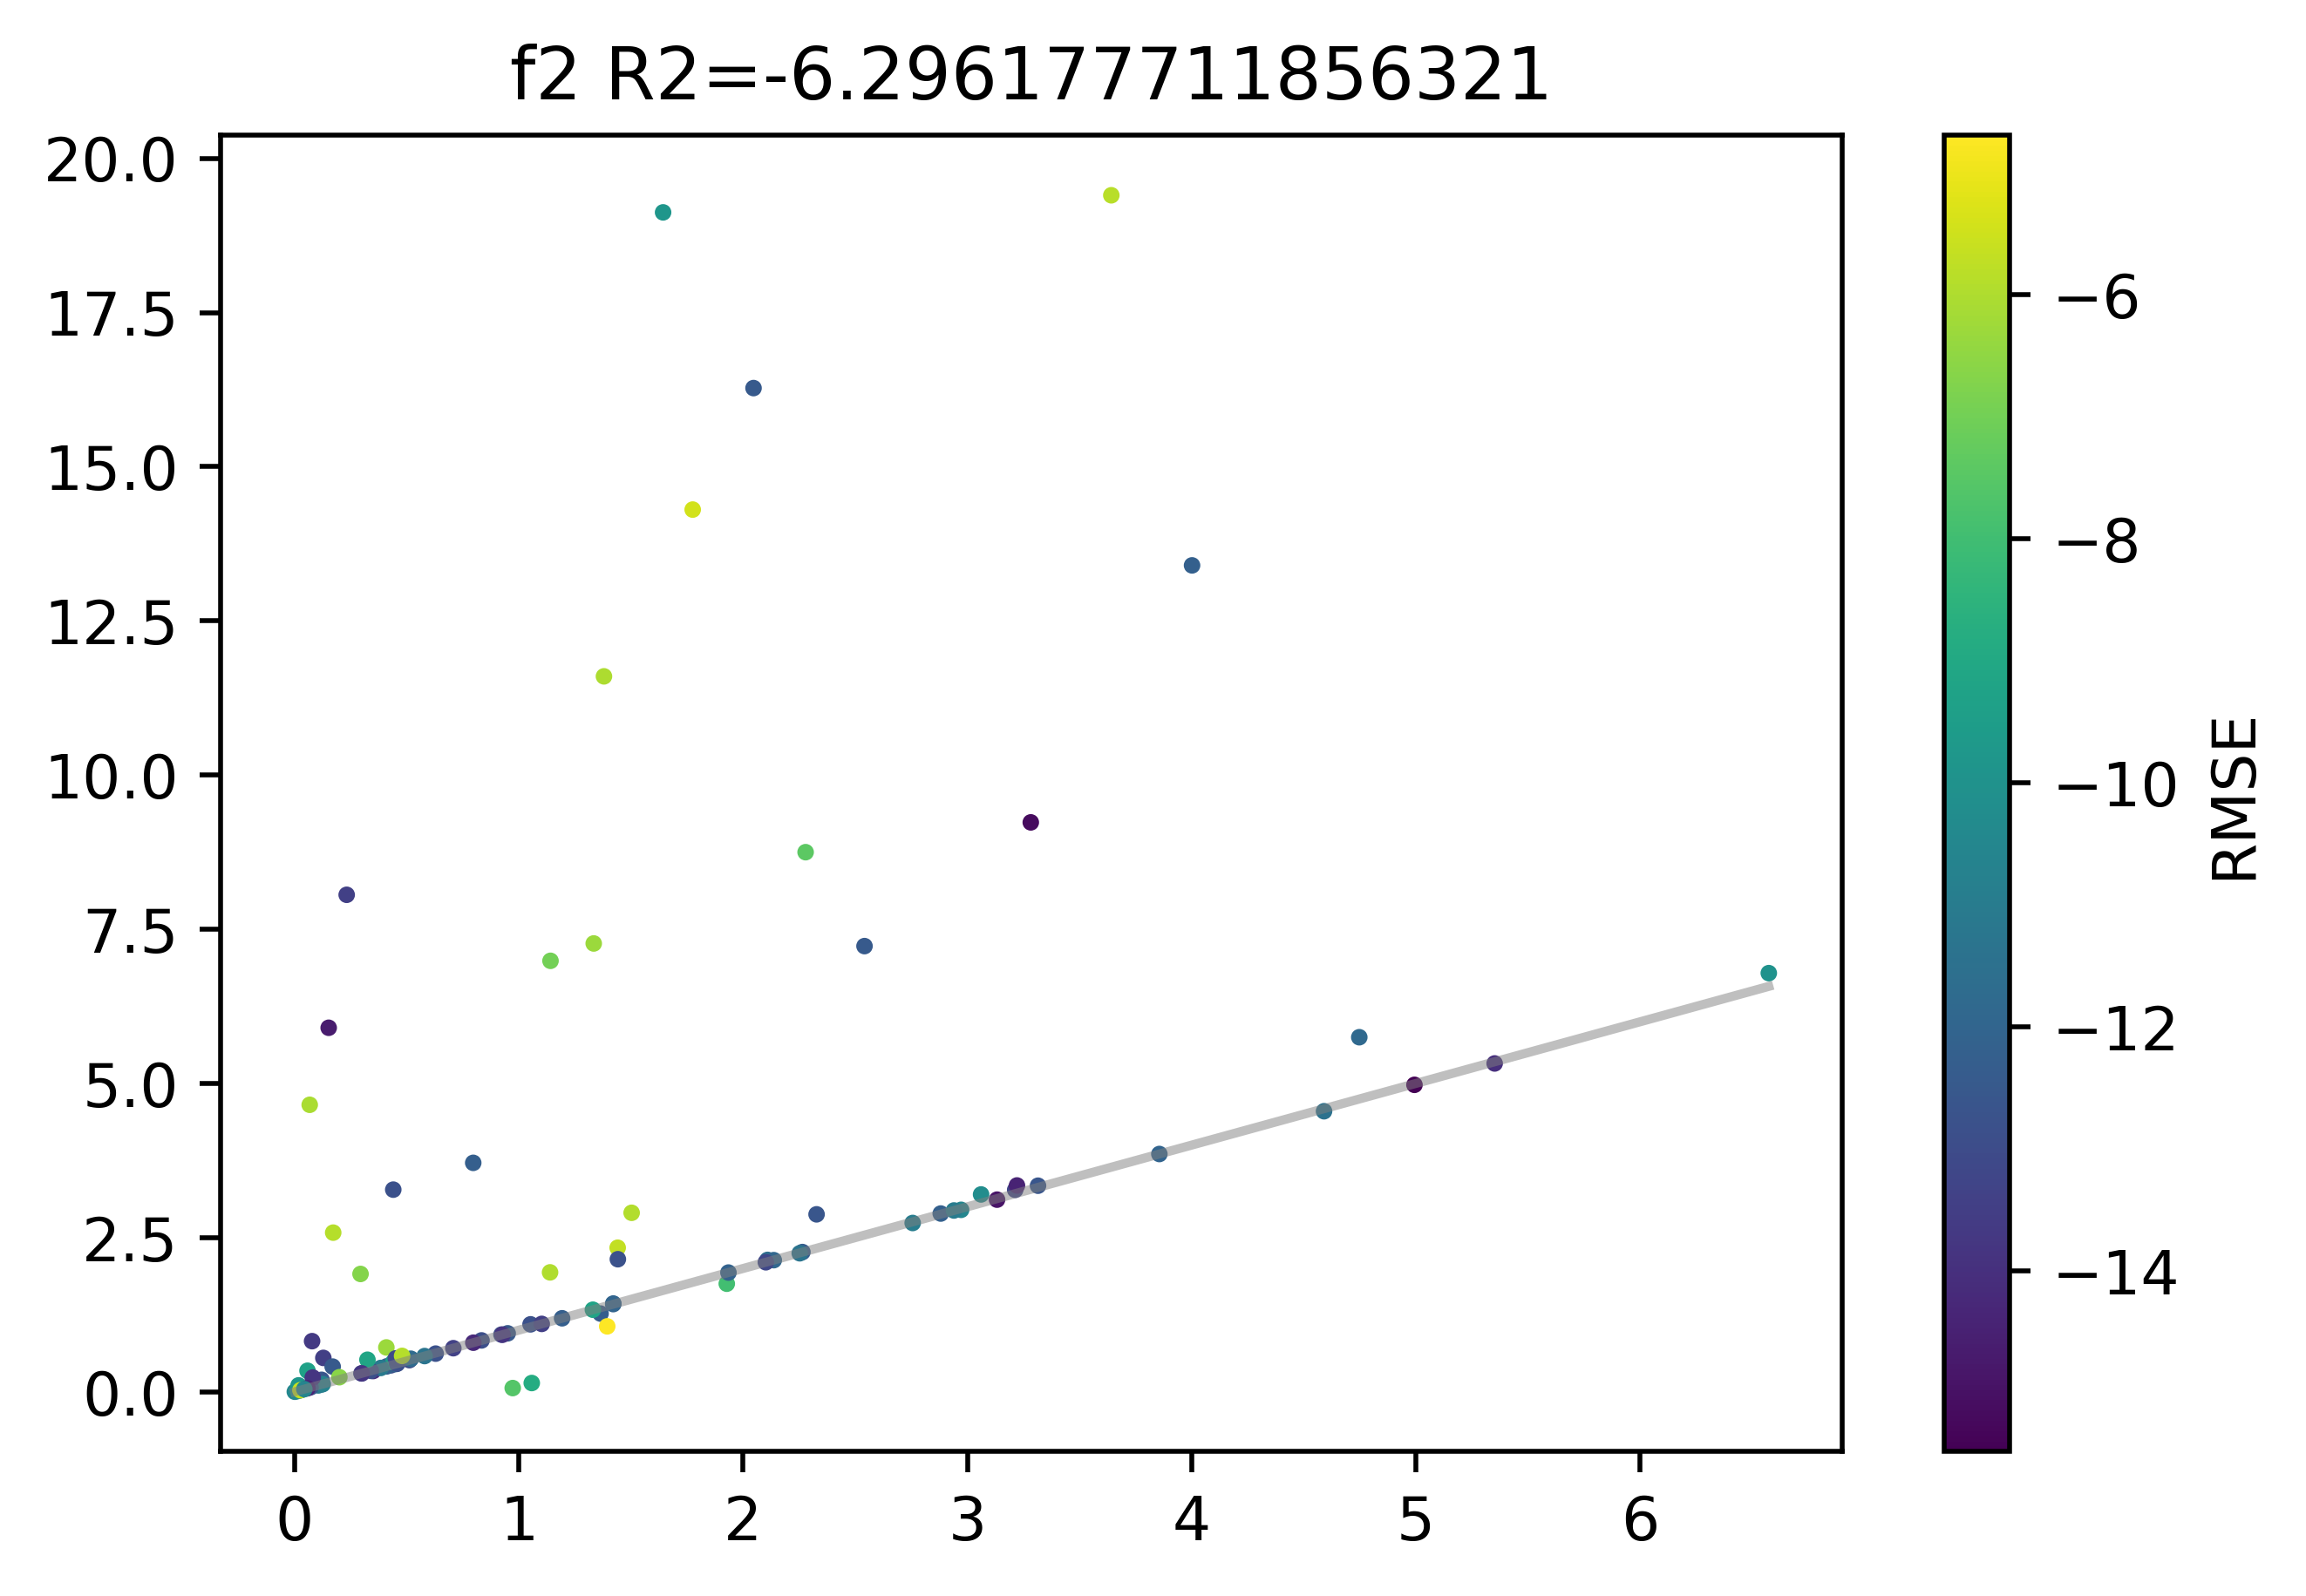

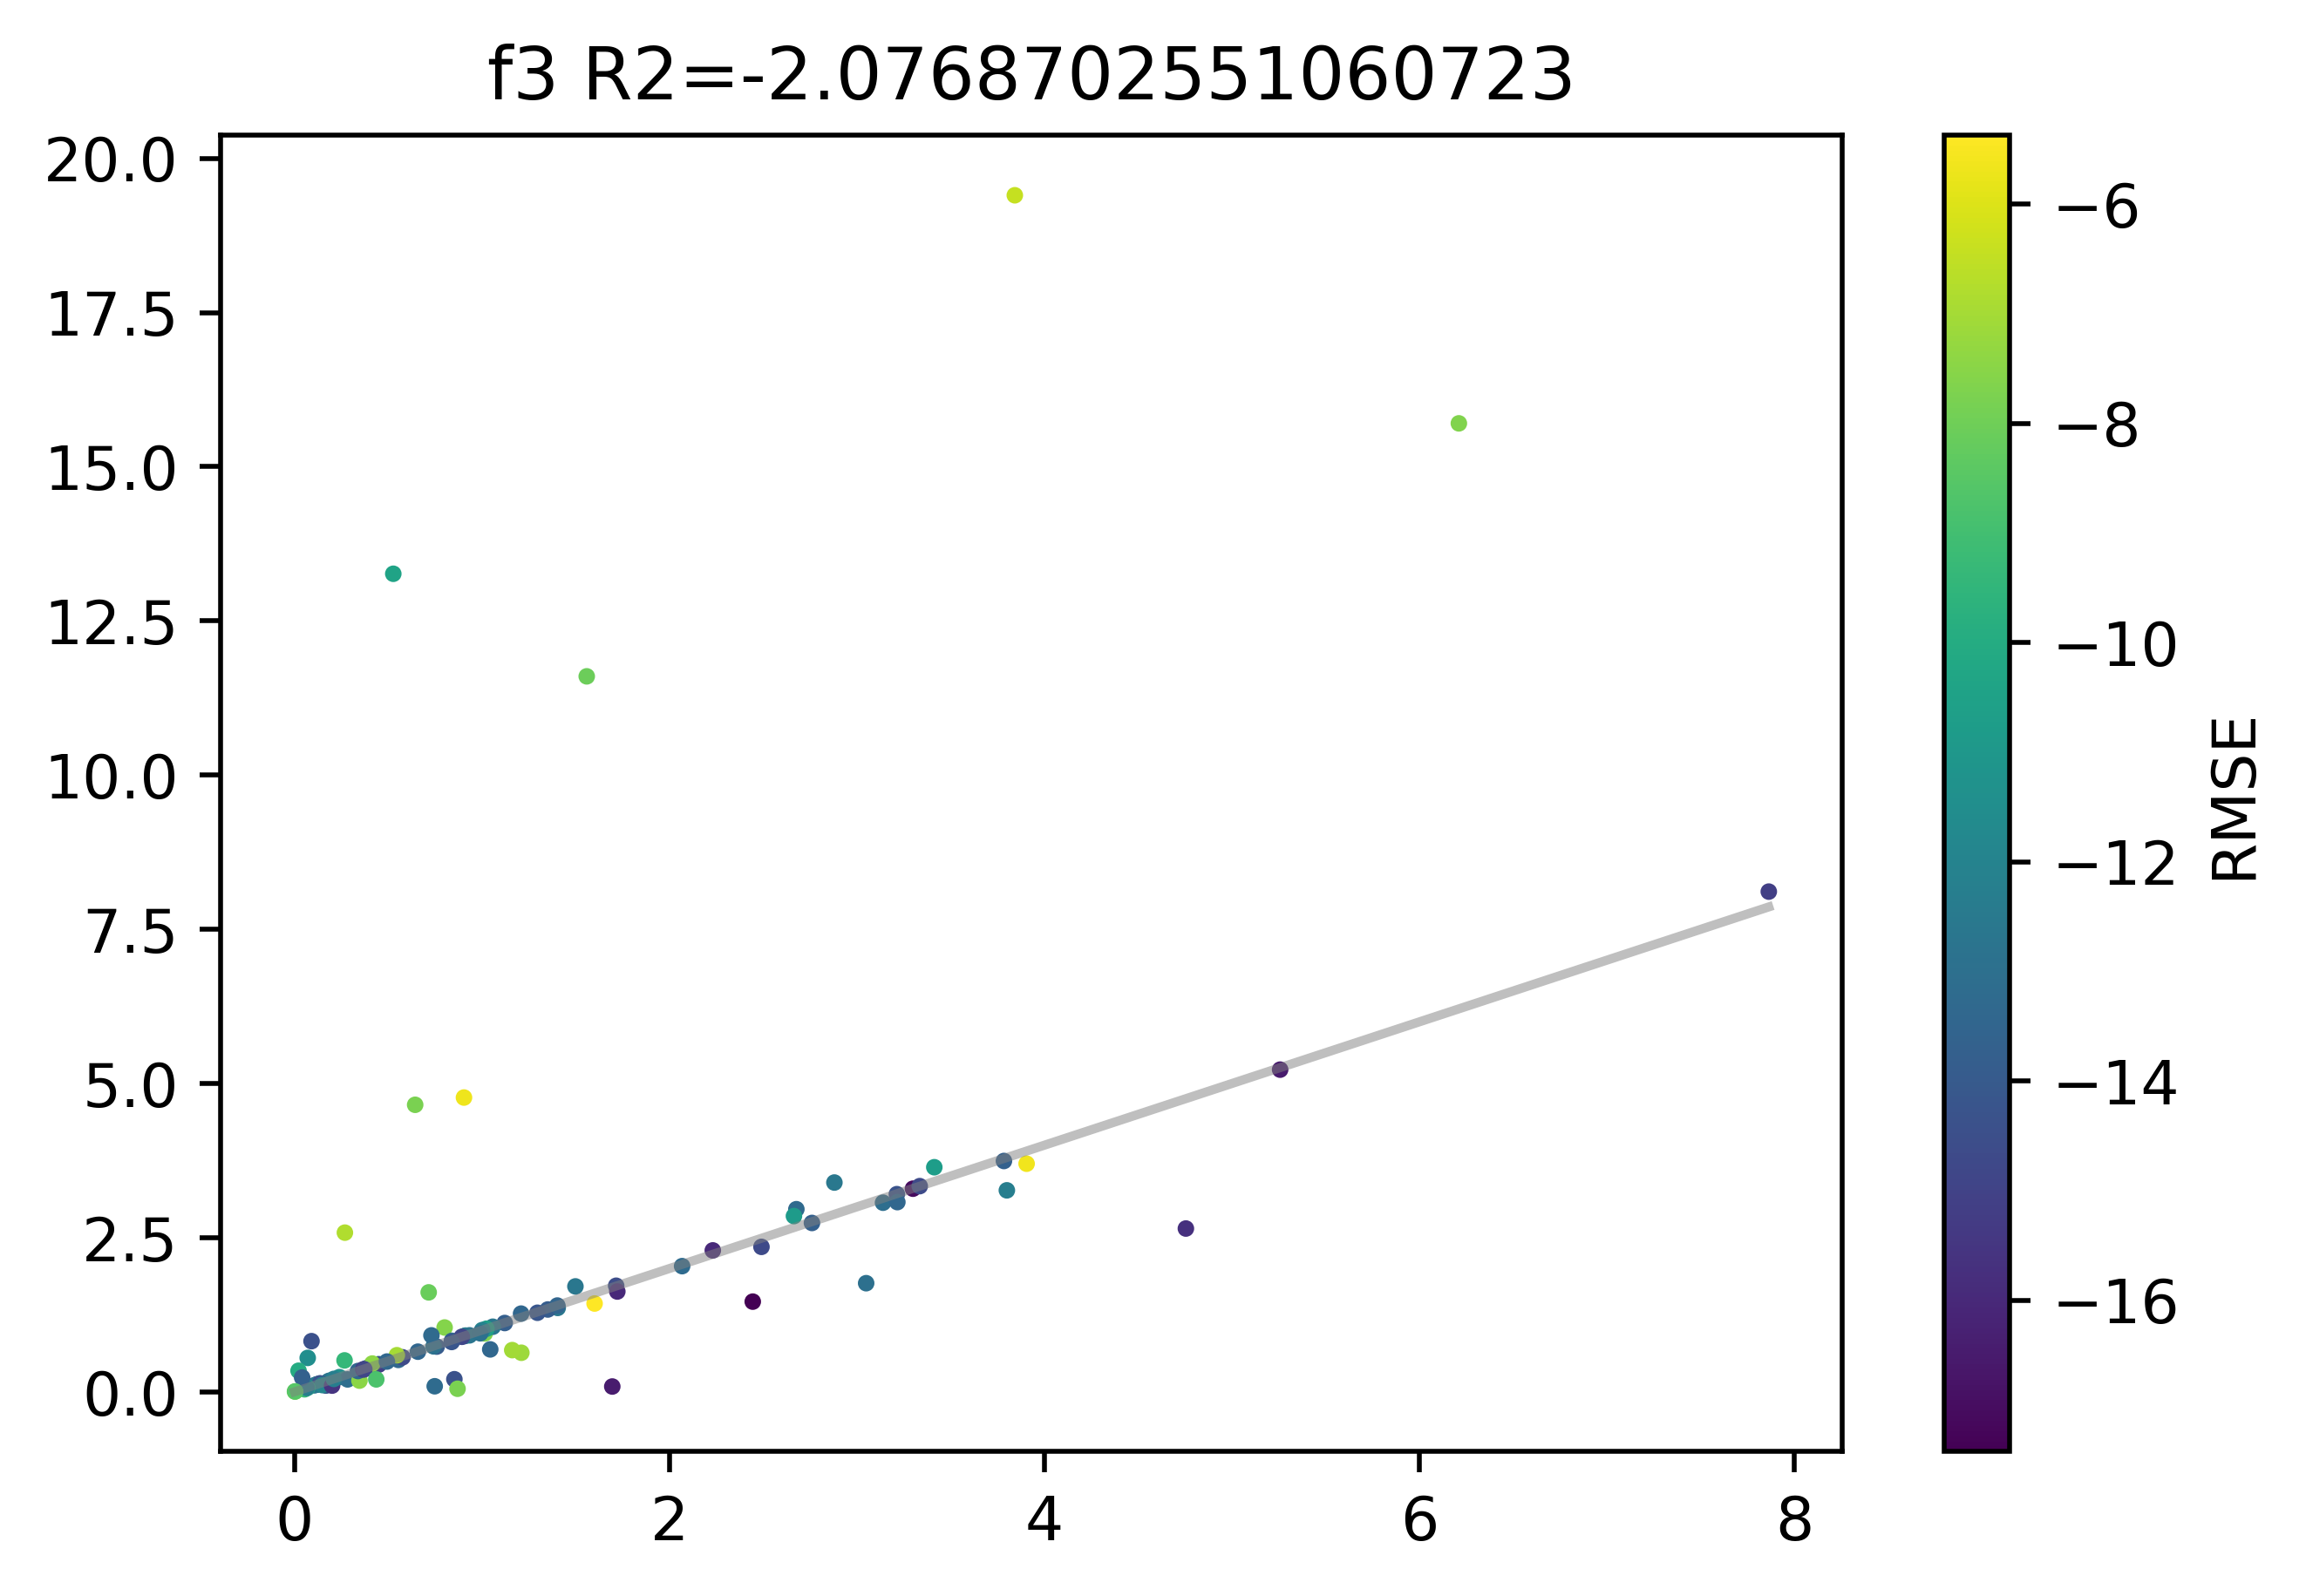

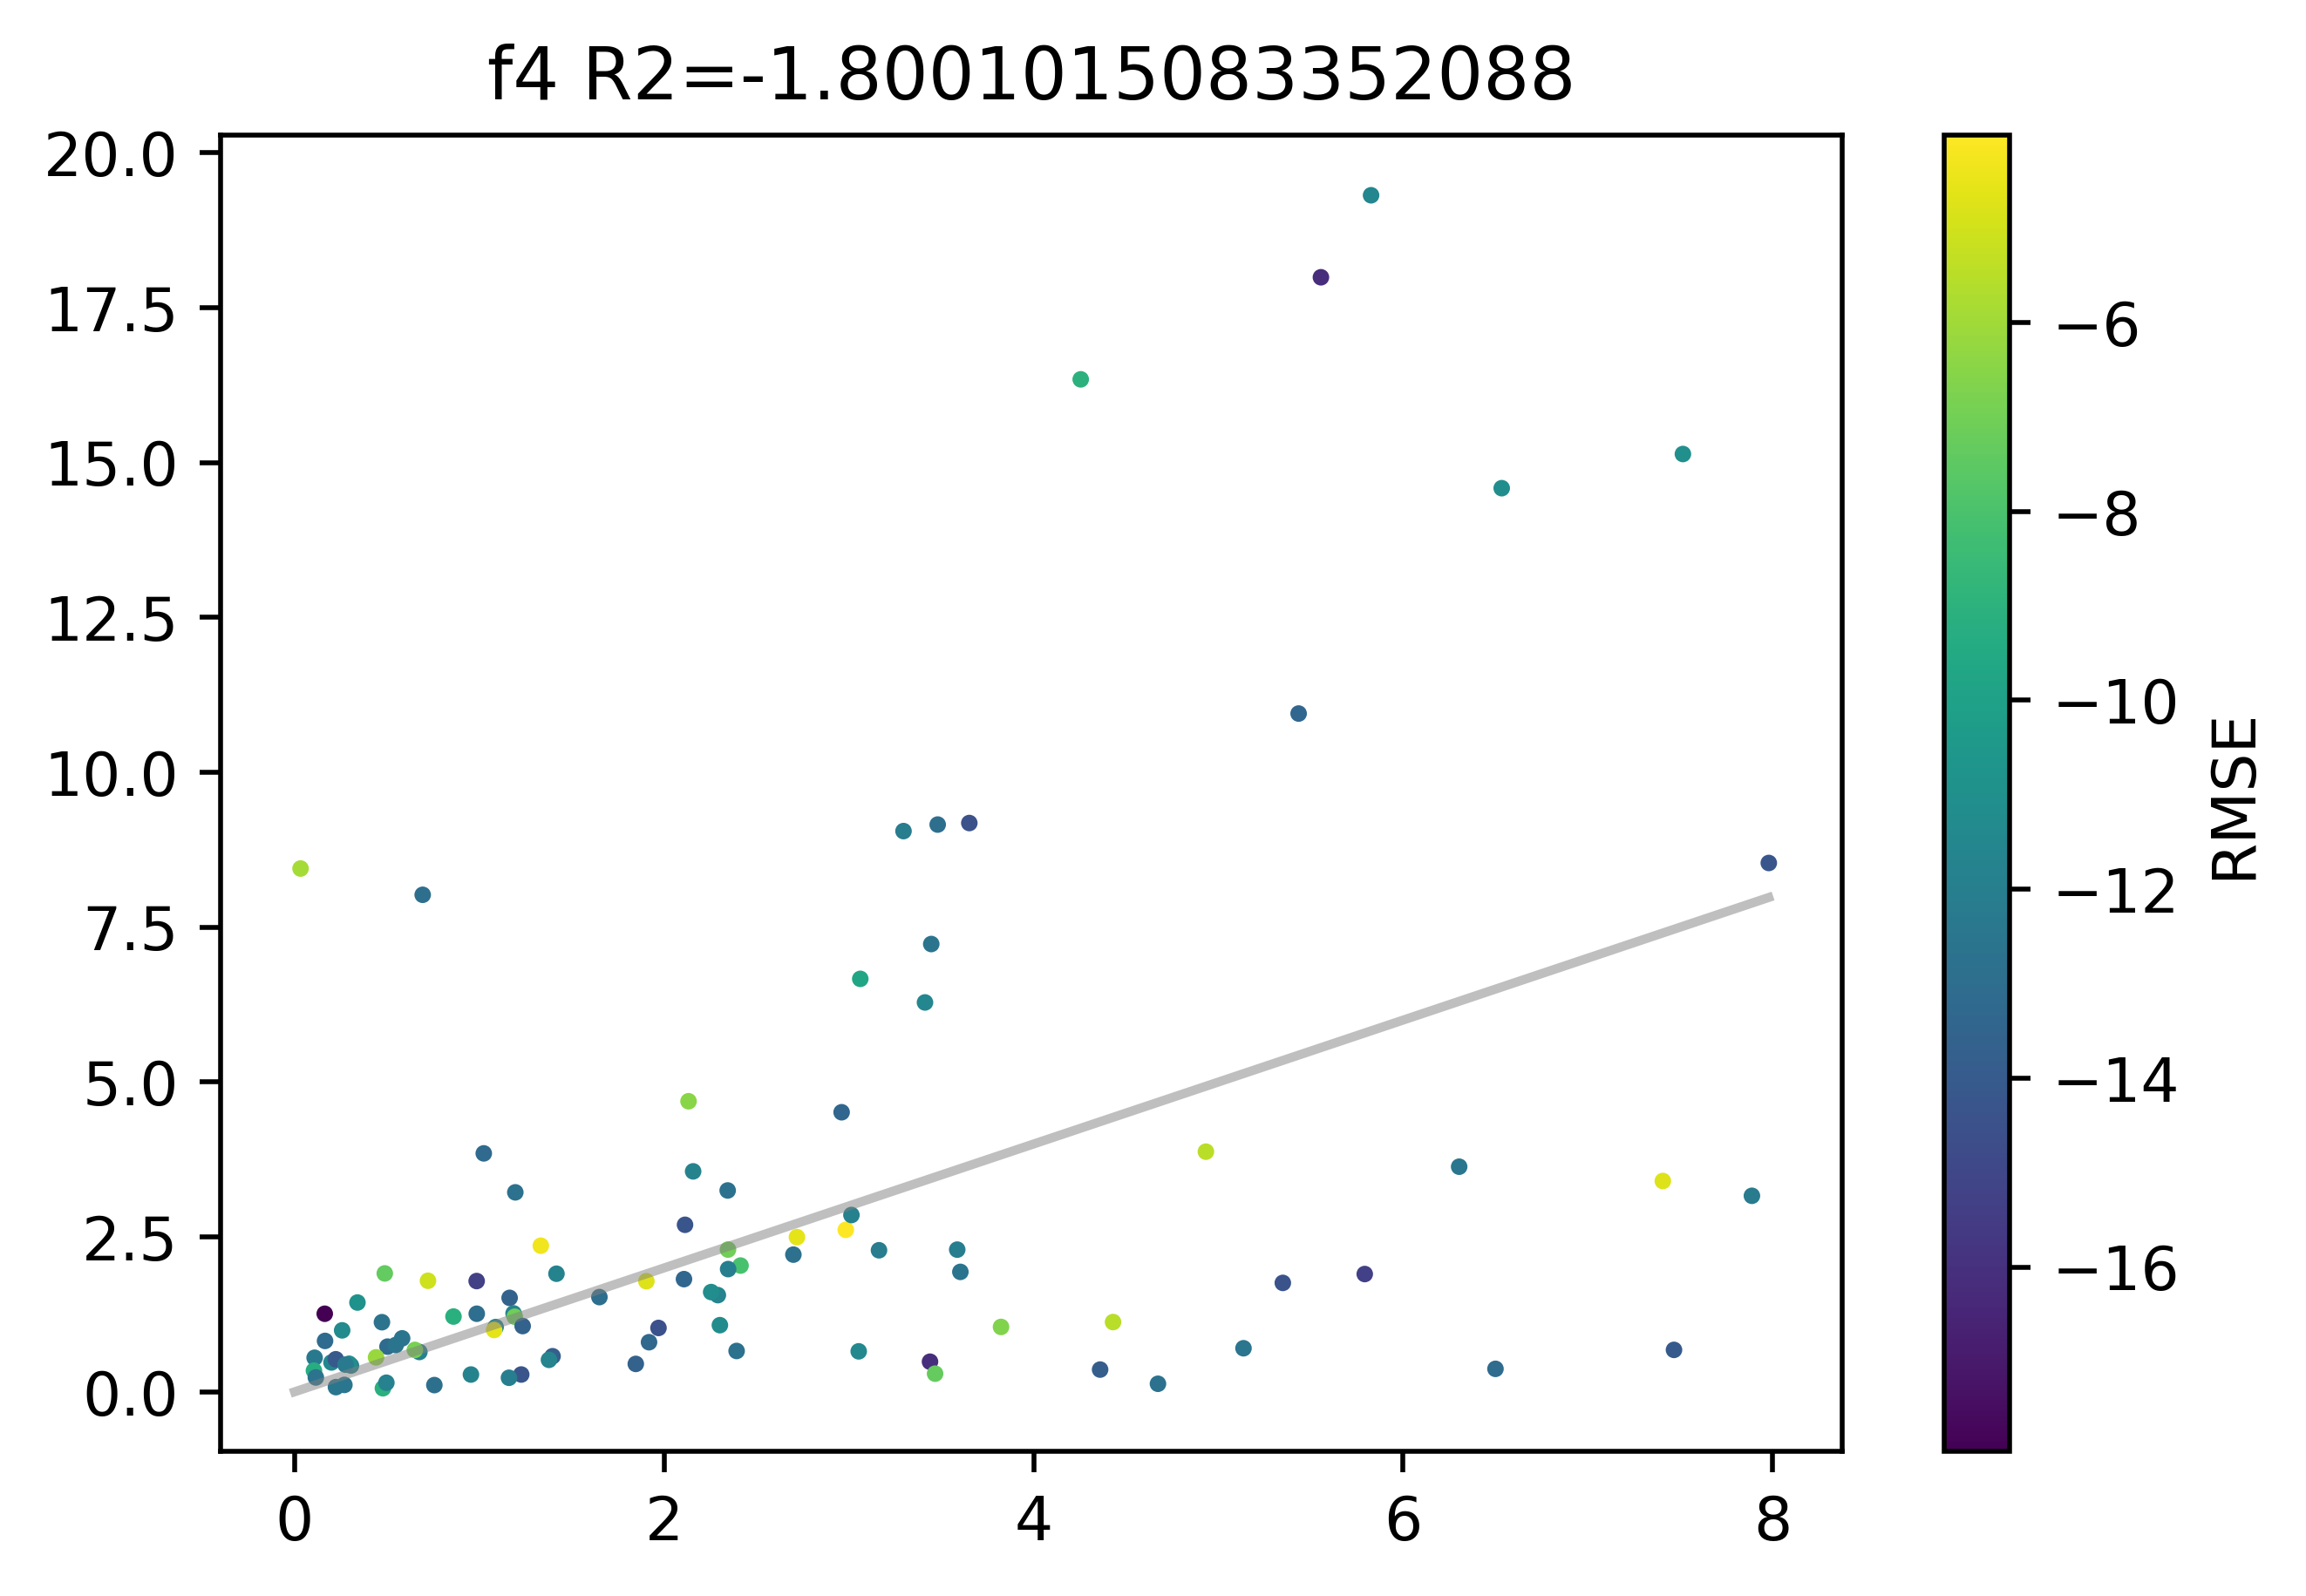

In [11]:
for x in range(pred.shape[1]):
    plt.figure()
    plt.scatter(true[:,x],pred[:,x],s=3,c=np.log10(err[:,x]))
    plt.plot([0,max(true[:,x])],[0,max(true[:,x])],color="grey",alpha=.5)
    plt.title("f" + str(x+1) + " R2=" + str(r2_score(true[:,x],pred[:,x])))
    #plt.ylim([0,max(true[:,x])])
    plt.colorbar(label="RMSE")

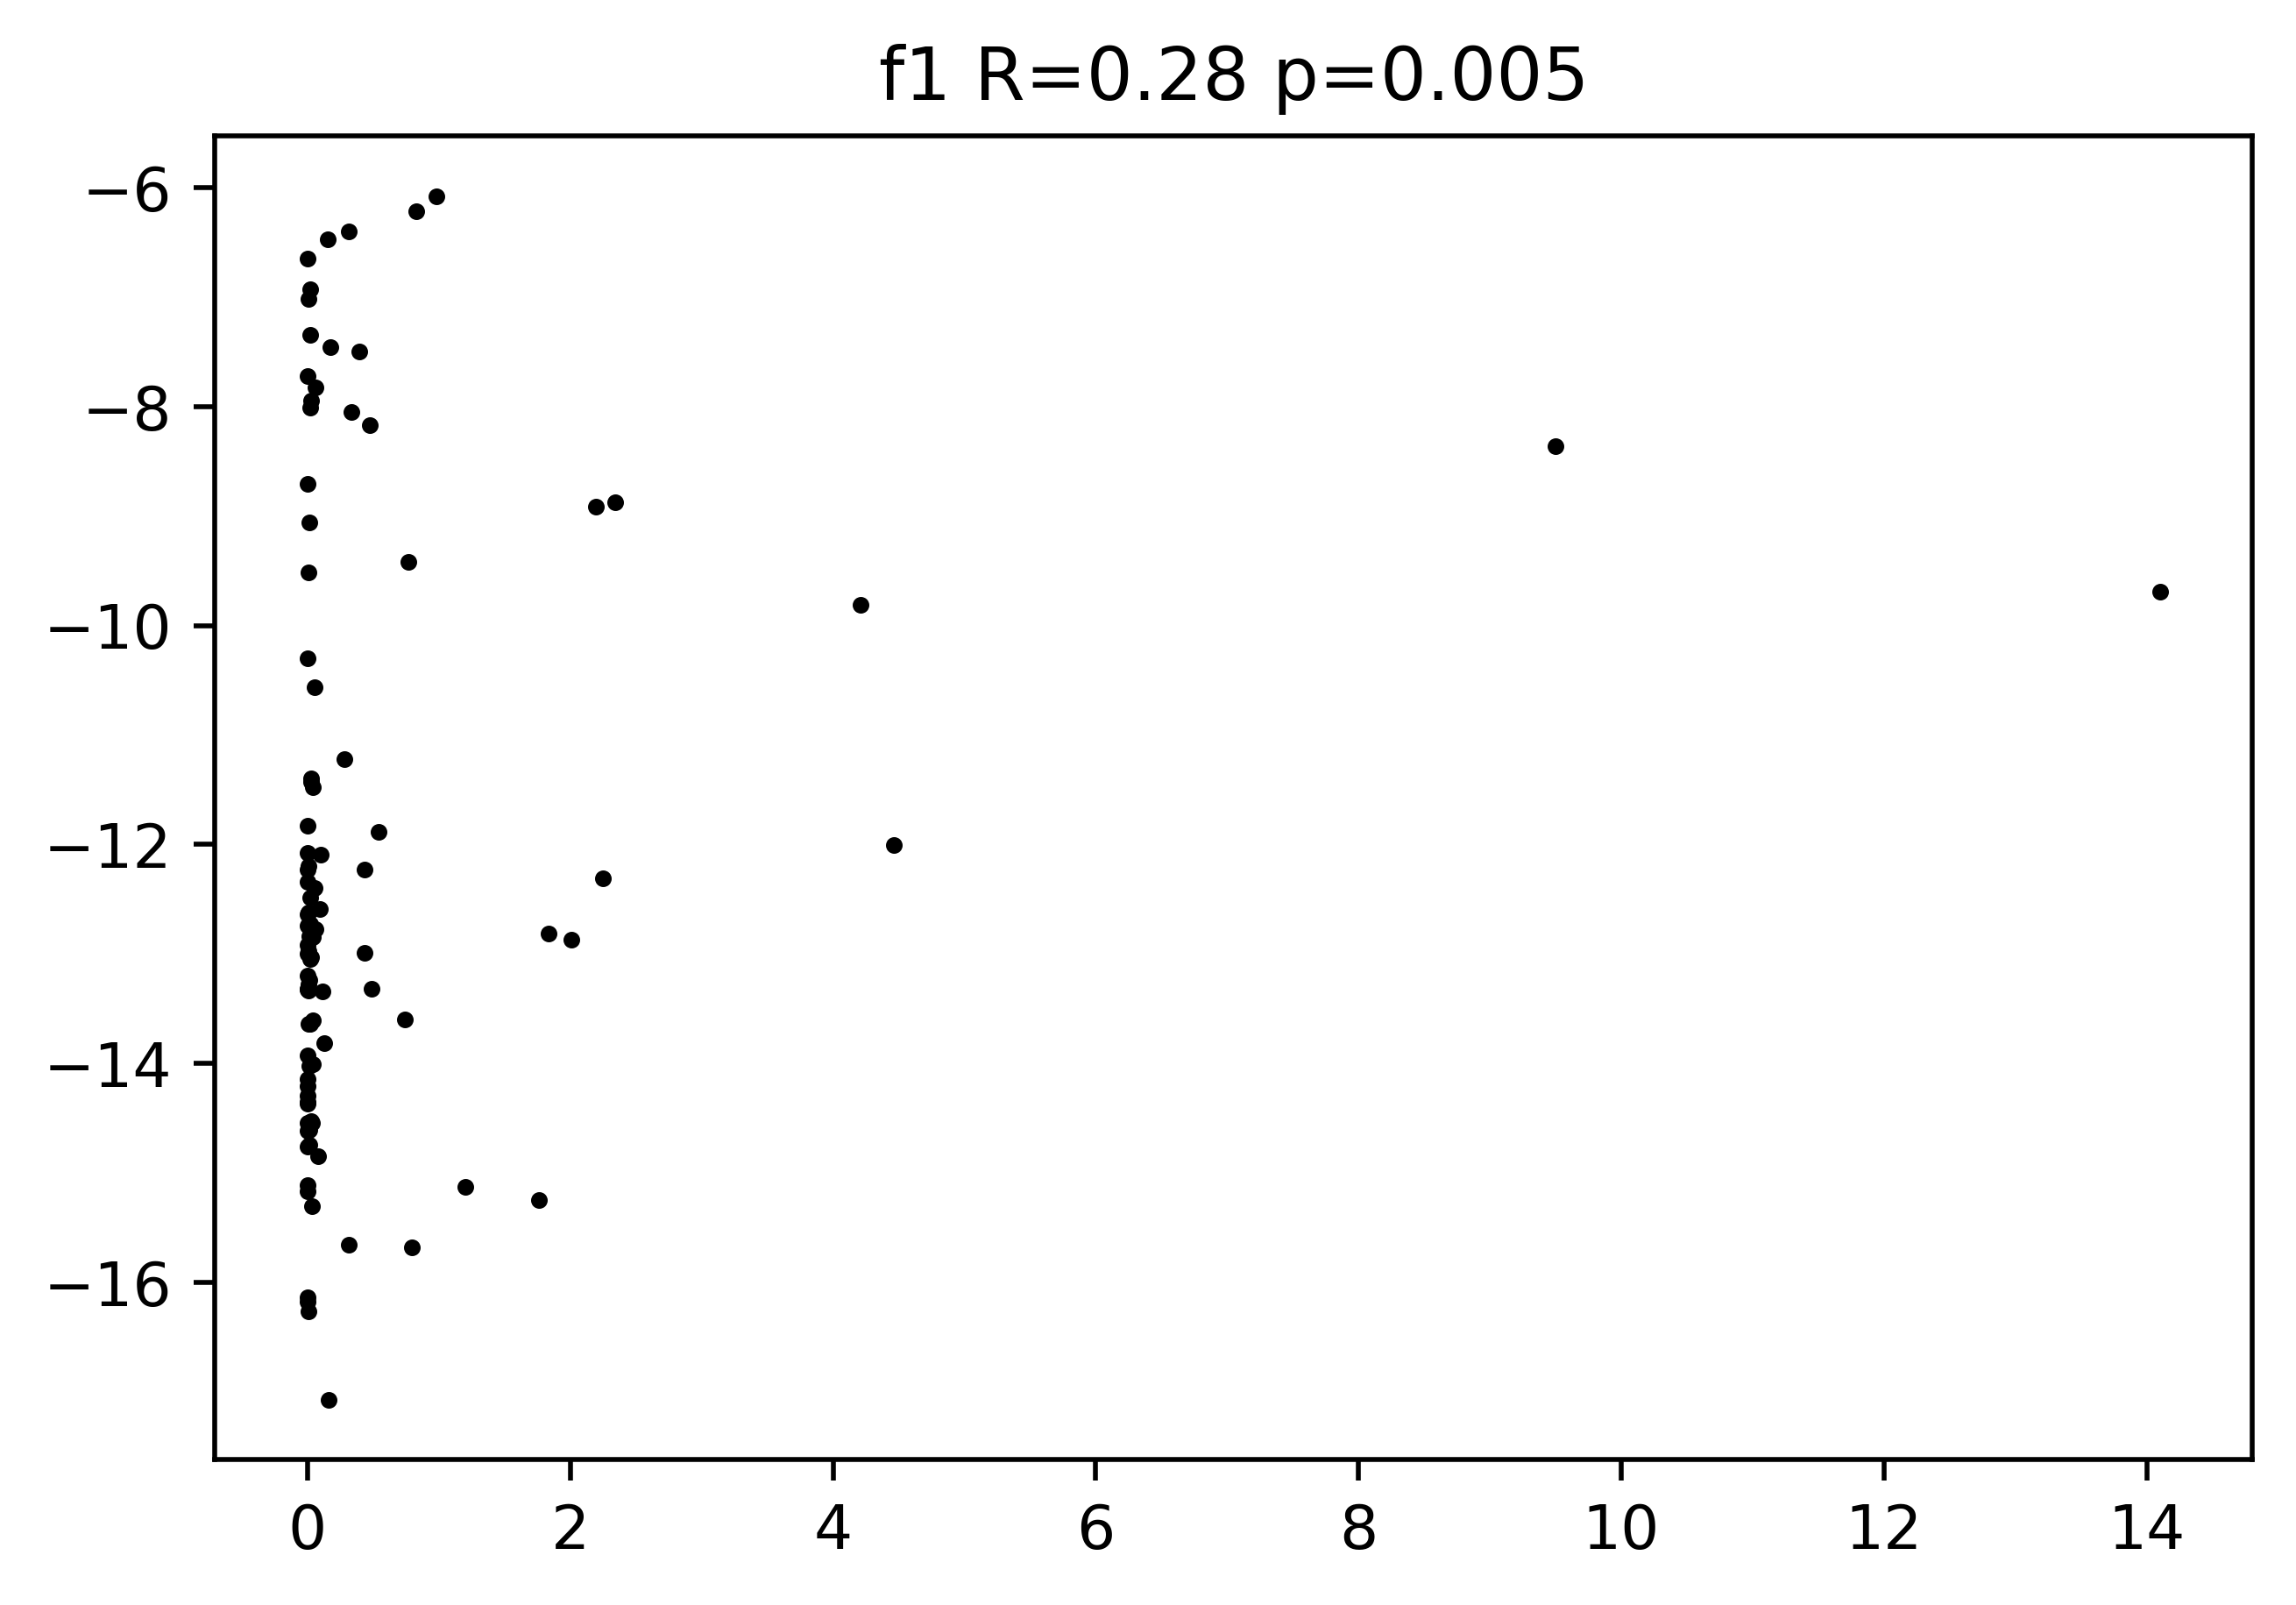

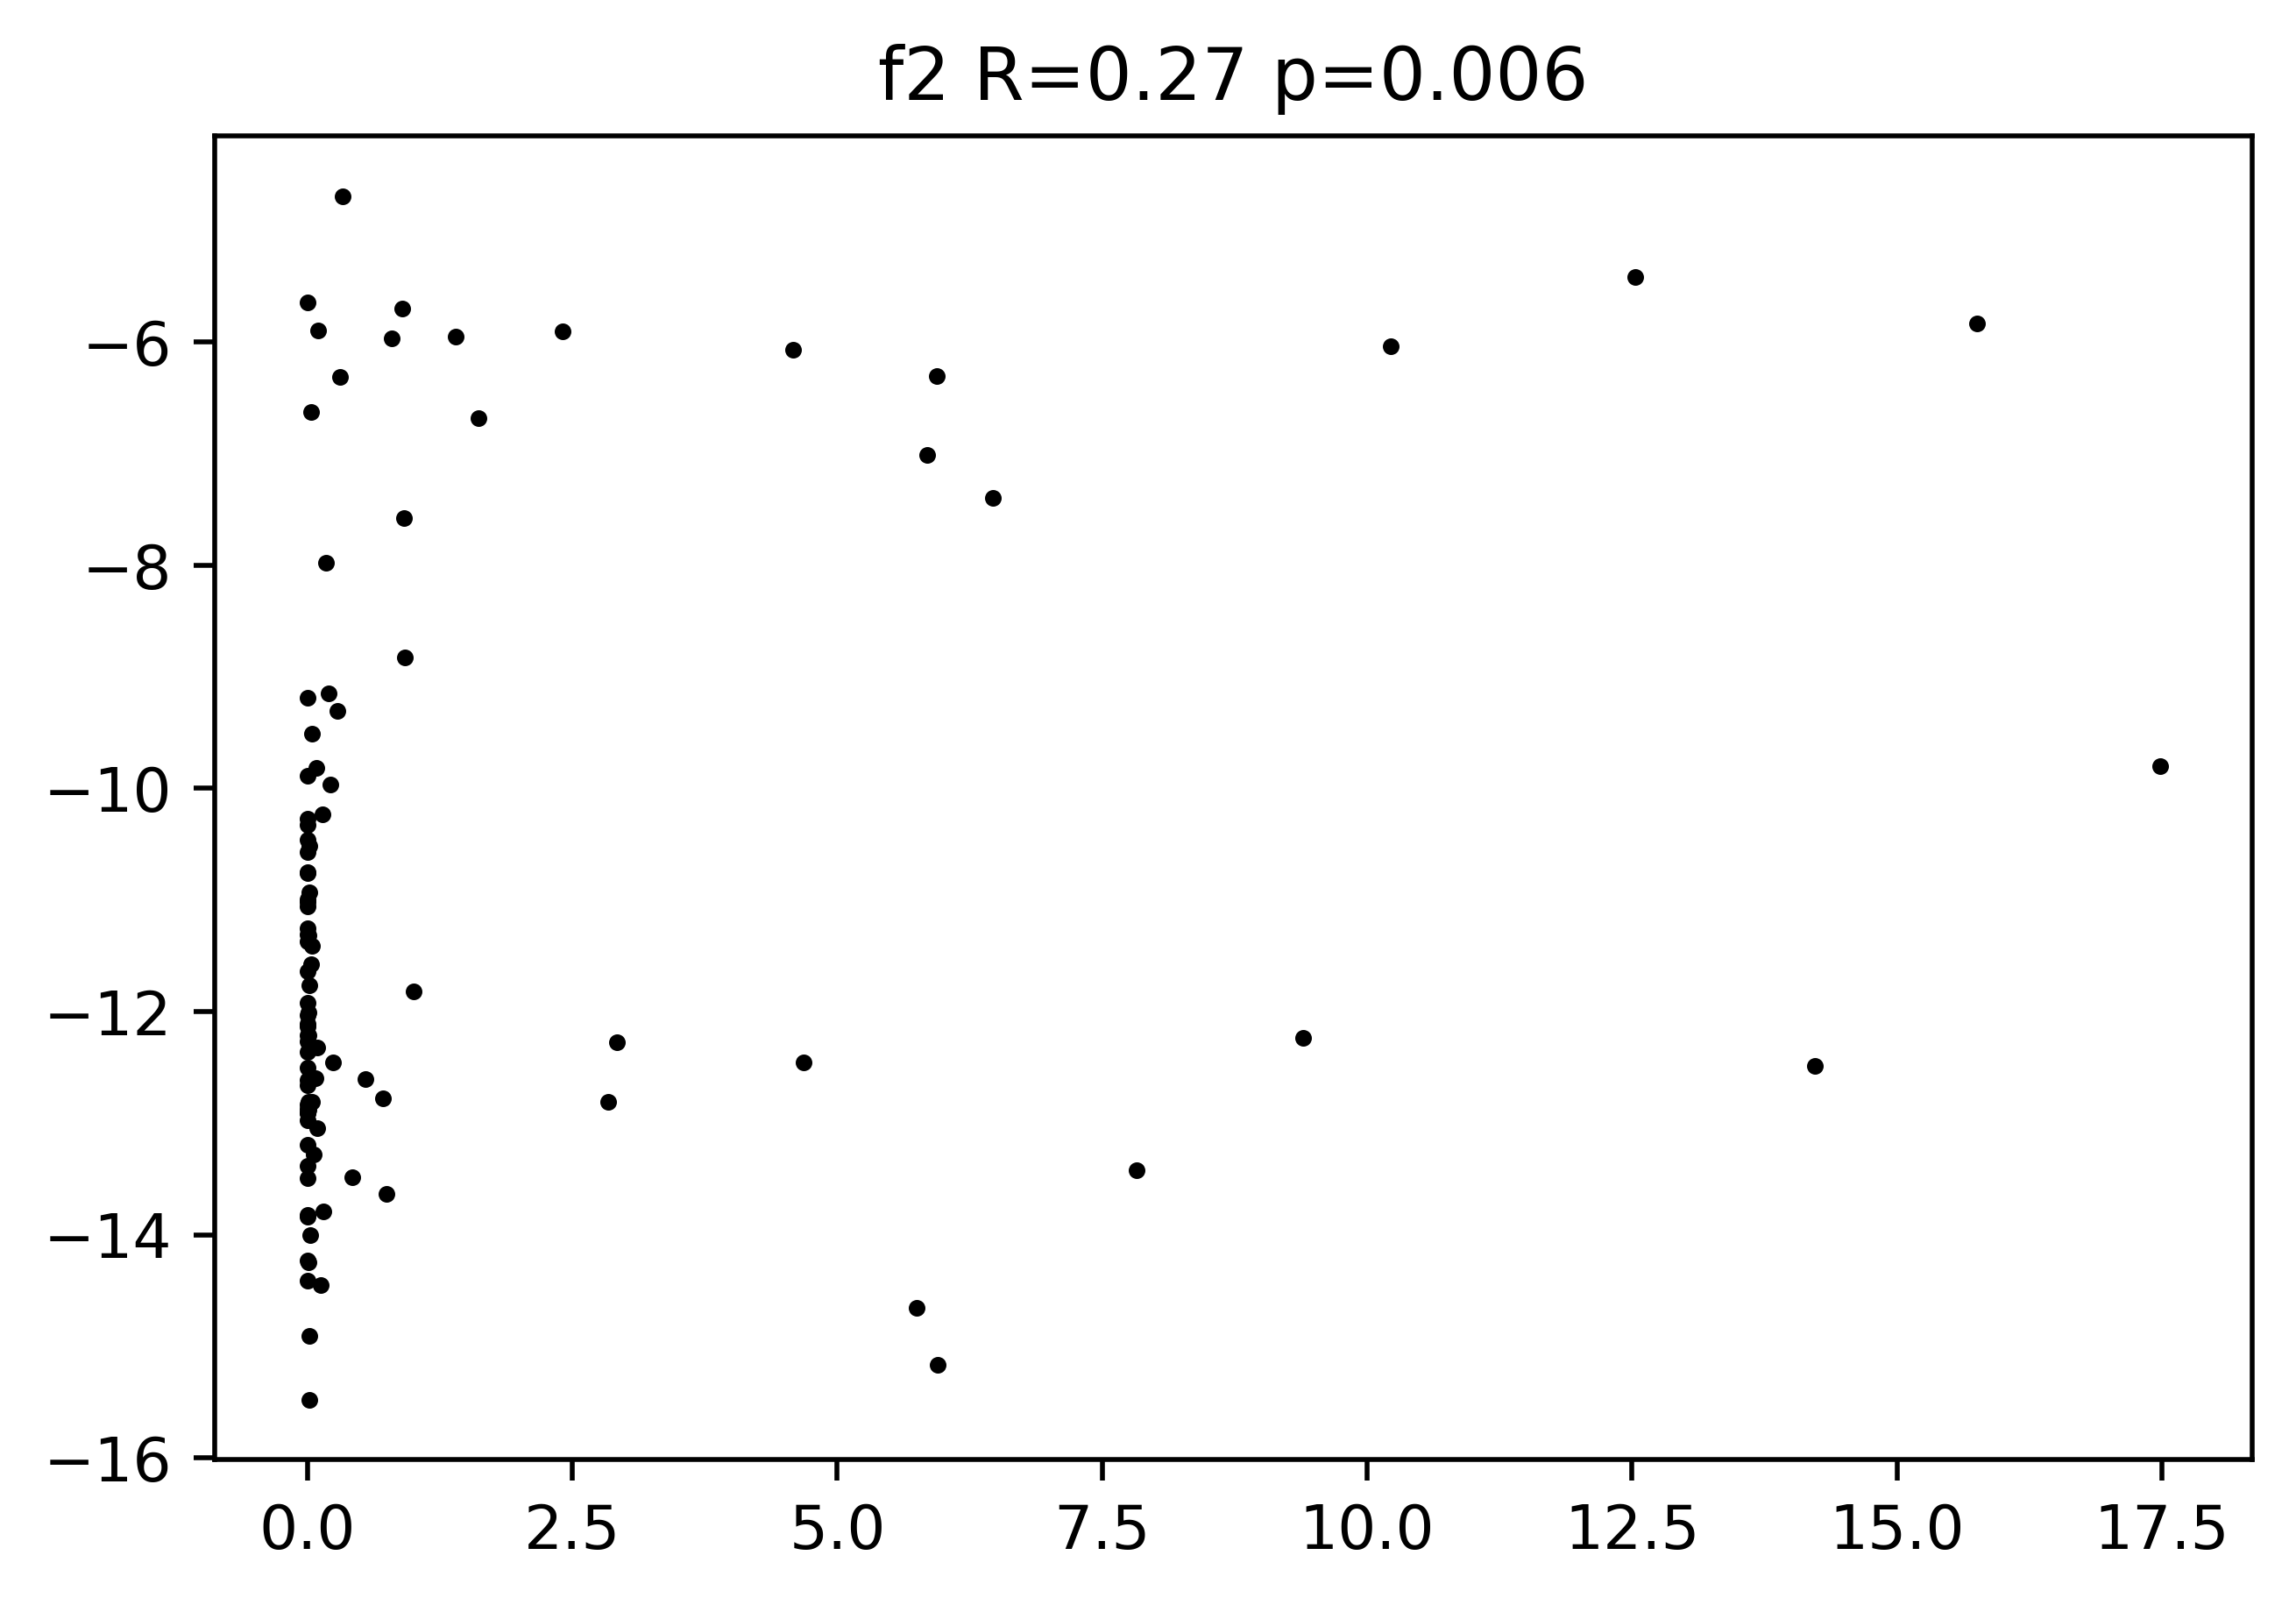

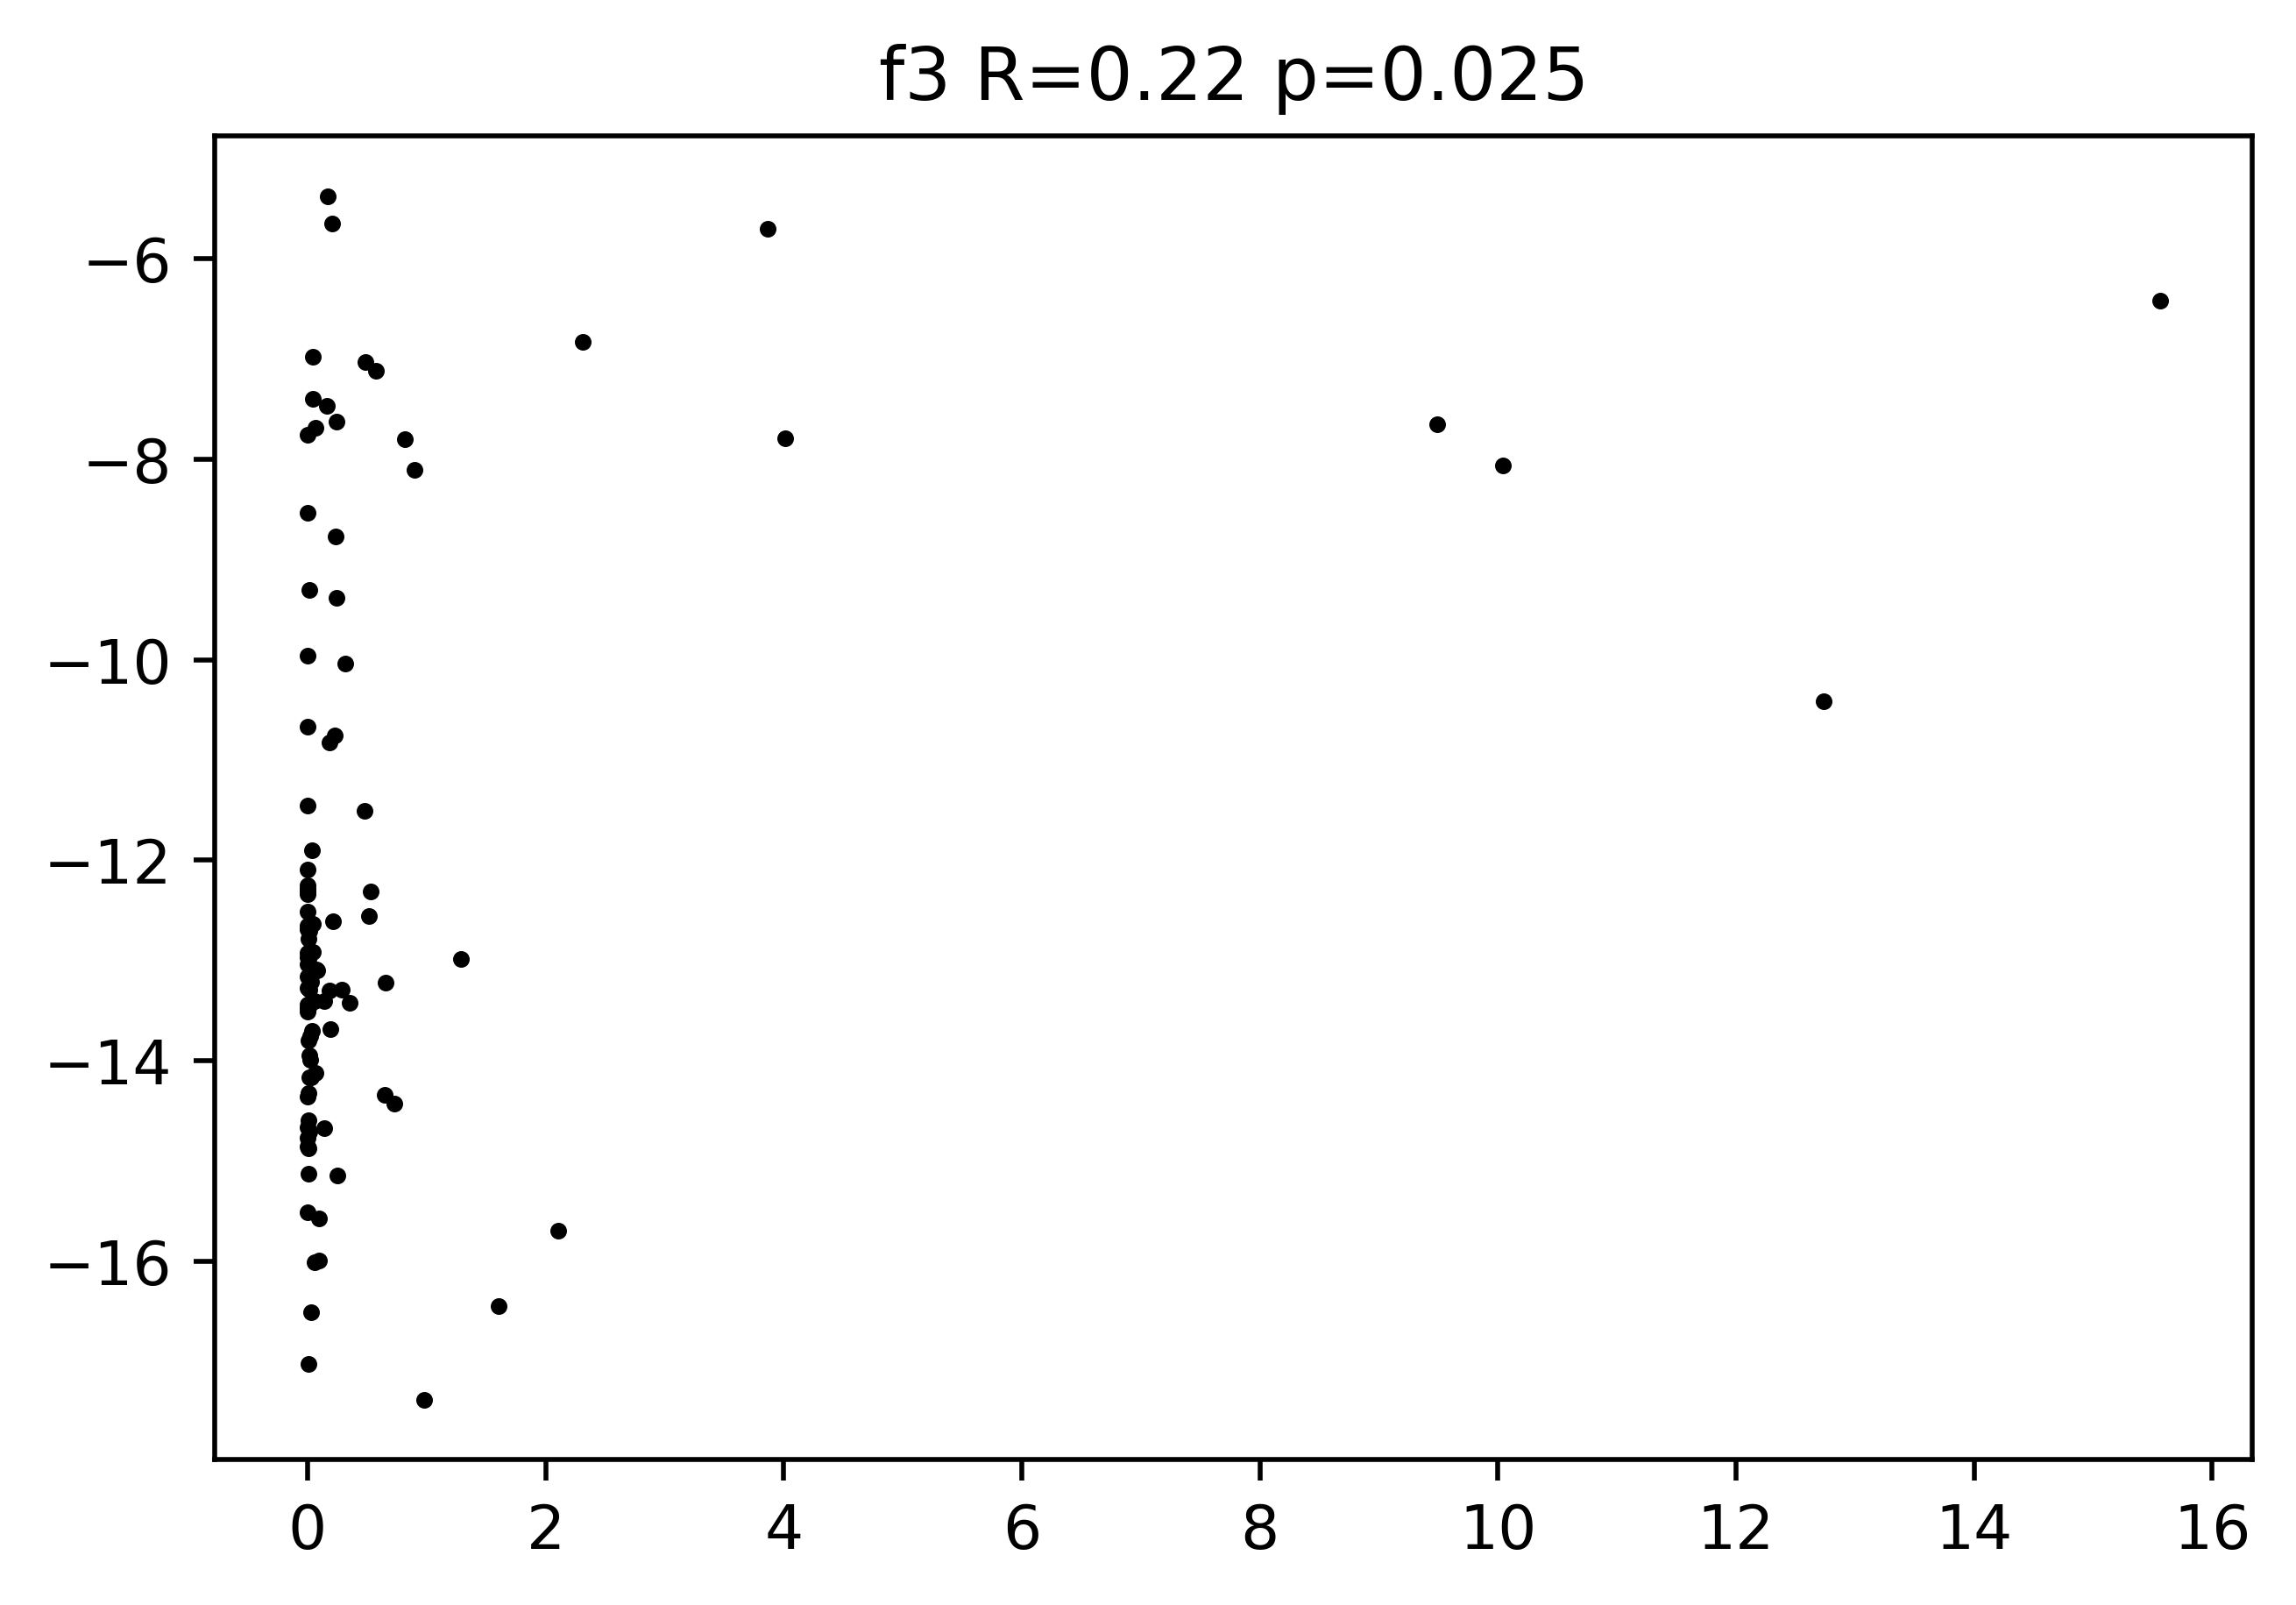

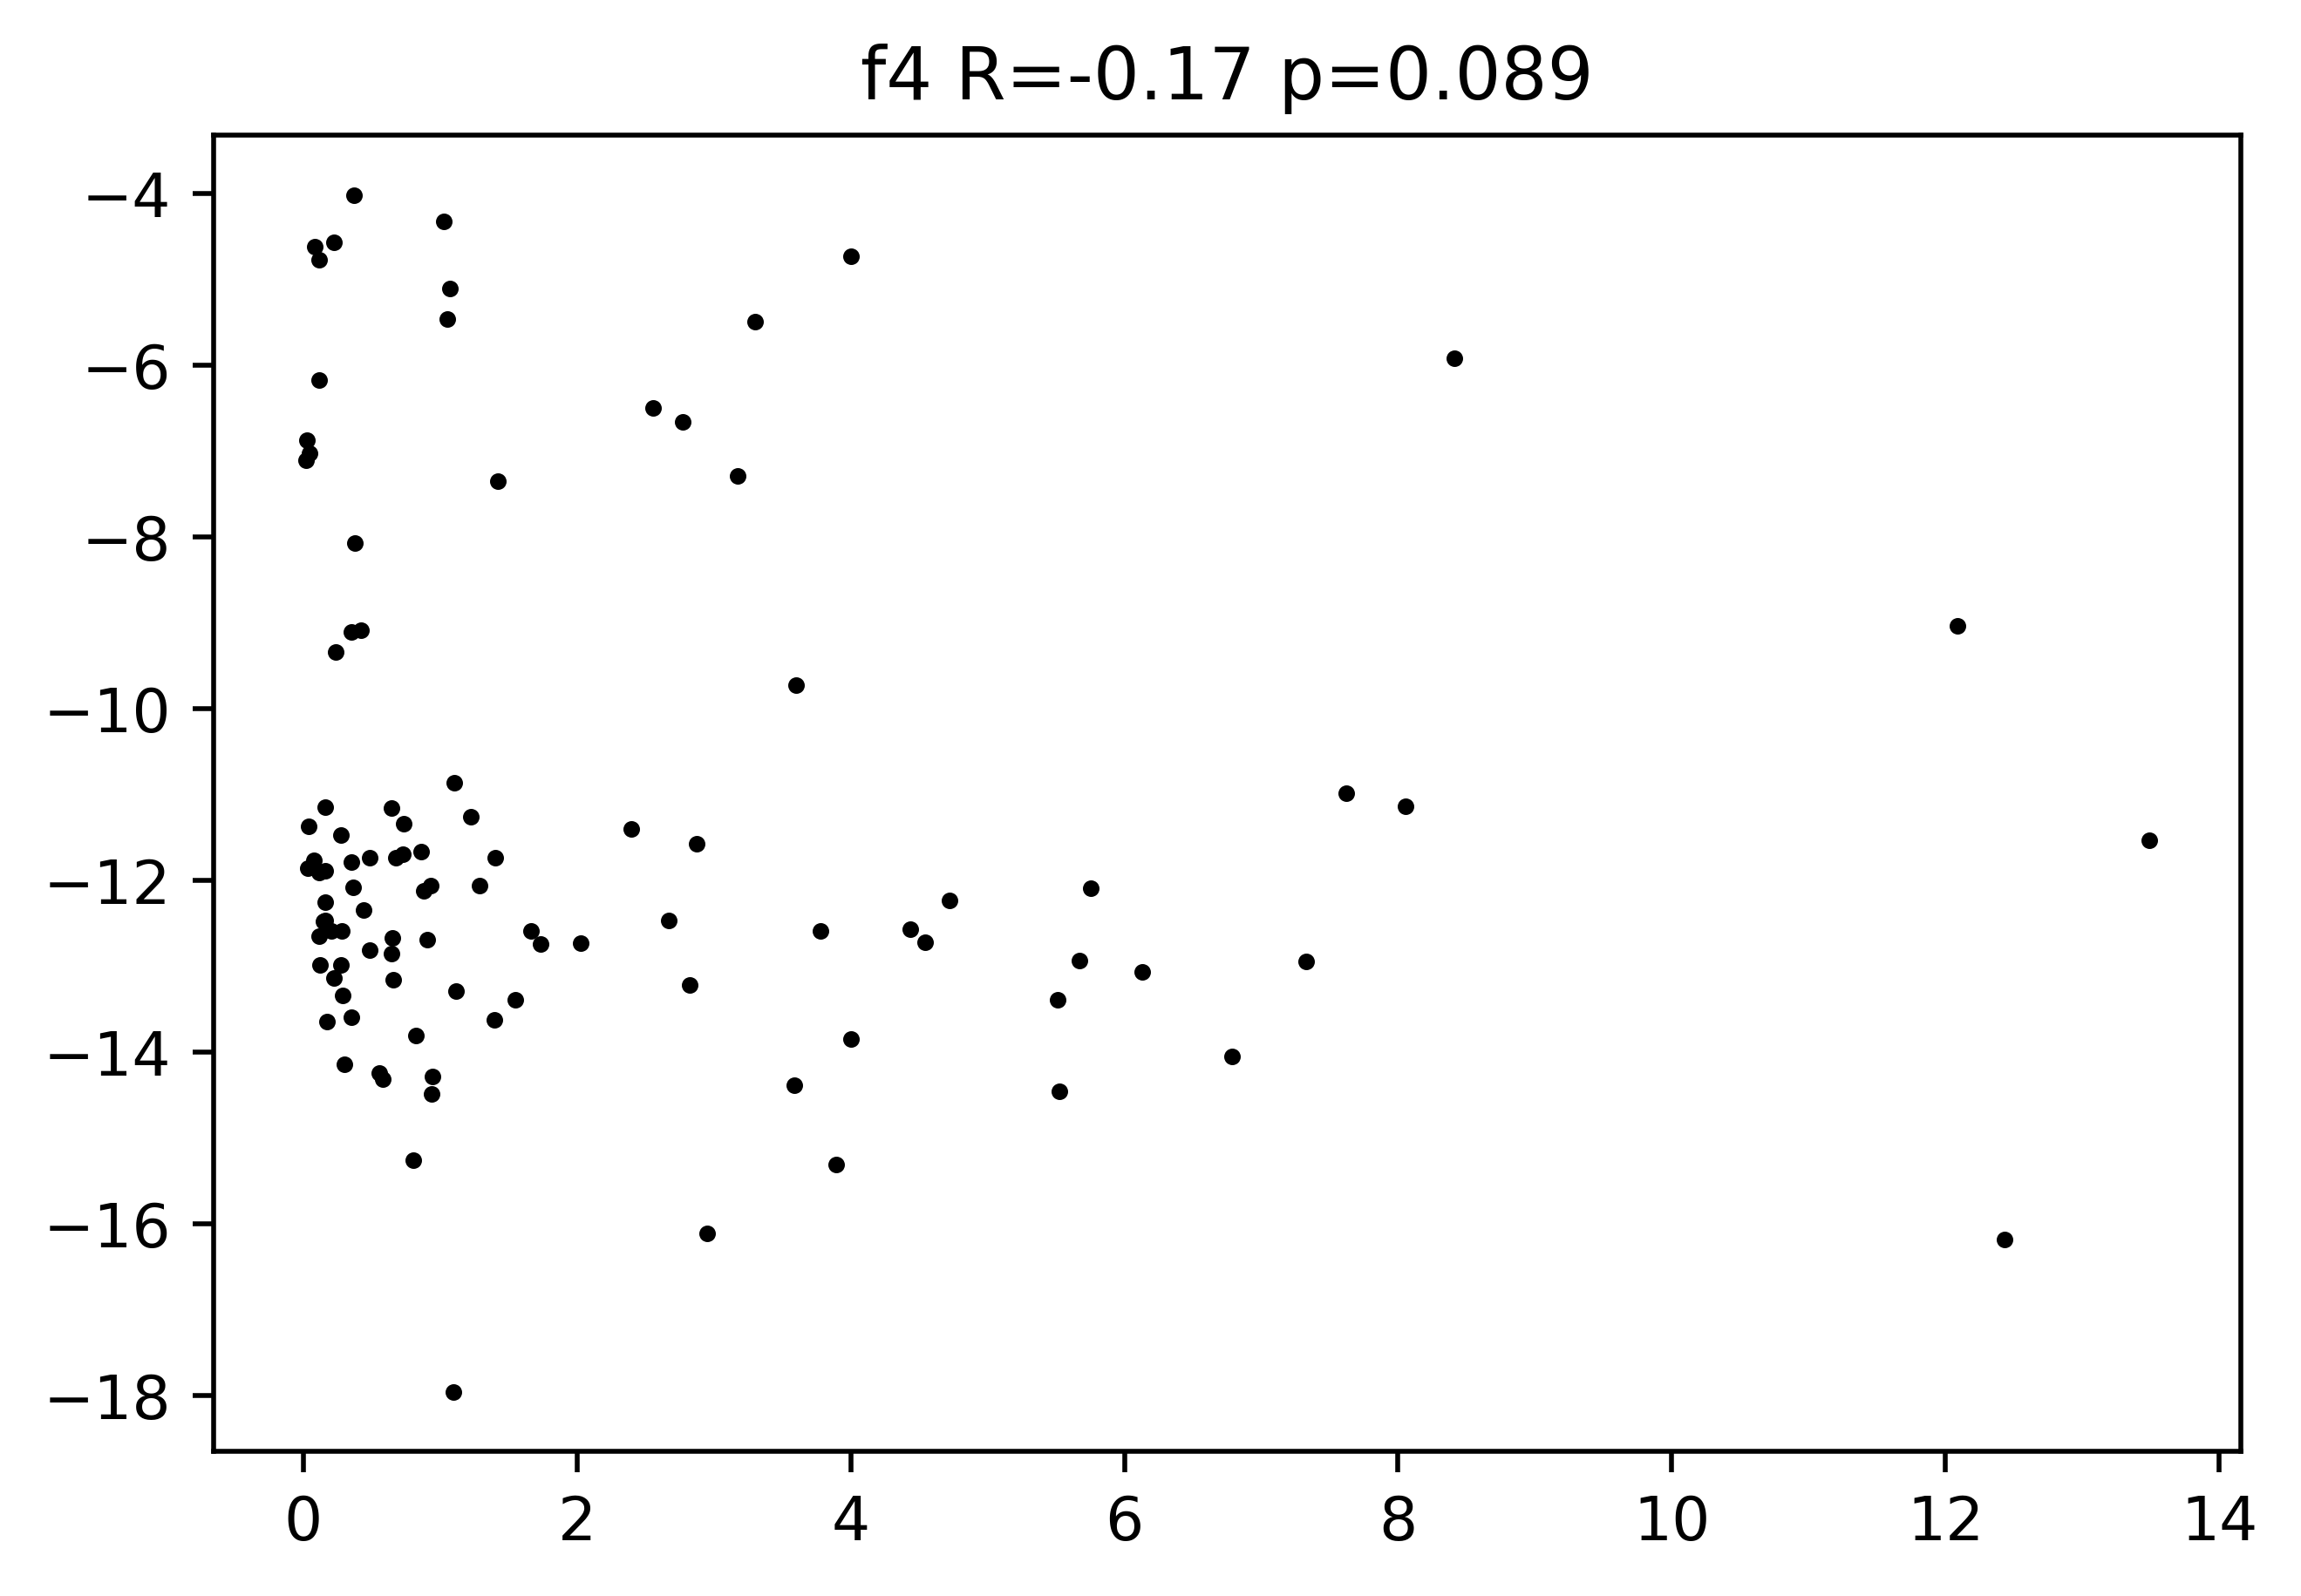

In [12]:
for x in range(pred.shape[1]):
    plt.figure()
    errs = np.abs(true[:,x]-pred[:,x])
    plt.scatter(errs,np.log10(err[:,x]),s=3,color="black")
    stat,p = stats.spearmanr(errs,err[:,x])
    plt.title("f" + str(x+1) + " R=" + str(np.round(stat,2)) + " p=" + str(np.round(p,3)))
